In [1]:
# Simulation relevant stuff
machine = 'mac'
#machine = 'magny'
machine = 'virgo'

if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
    filedir = "/home/extmilan/masterthesis/files/"
    plotdir = "/home/extmilan/masterthesis/plots/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
    filedir = "/Users/smilanov/Documents/masterthesis/auriga_files/files/"
    plotdir = "/Users/smilanov/Documents/masterthesis/auriga_files/plots/"
elif machine == 'virgo': 
    basedir = "/virgo/simulations/Auriga/level4_MHD/"
    filedir = "/u/milas/masterthesis/masterproject/files/"
    plotdir = "/u/milas/masterthesis/masterproject/plots/"
    


In [2]:
import sys
sys.path.append("..")
from galpy.potential import NFWPotential as NFWpot
from galpy.potential import HernquistPotential as HEpot
from galpy.potential import DoubleExponentialDiskPotential as DEpot
from galpy.potential import MiyamotoNagaiPotential as MNpot
from galpy.potential import MN3ExponentialDiskPotential as MN3pot
from galpy.potential import MWPotential2014
from galpy.potential import evaluatePotentials, MiyamotoNagaiPotential, NFWPotential, HernquistPotential


from galpy.potential import evaluateDensities, evaluatePotentials
from galpy.potential import plotDensities
from galpy.potential import plotRotcurve
from galpy.util import bovy_conversion

import emcee

import numpy as np

from scipy import optimize as opt
from scipy import integrate

from astropy import units

from IPython.display import display

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind


import datetime
import random

%matplotlib inline


import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
from decomposition import *
import matplotlib.pyplot as plt

from matplotlib import rcParams
import copy

from scipy import stats

%matplotlib inline

rcParams['font.size'] = 16
rcParams['lines.linewidth'] = 1.5
rcParams['axes.linewidth'] = 1.5
rcParams['ytick.major.width'] = 1.5
rcParams['xtick.major.width'] = 1.5
rcParams['image.cmap'] = 'magma'
rcParams['figure.figsize'] = (6.5,5.)
rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.dpi'] = 300
rcParams['savefig.format'] = 'png'
cmap = copy.copy(plt.cm.get_cmap(rcParams['image.cmap']))
cmap.set_bad((0,0,0))
%config InlineBackend.figure_format = 'retina'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Build the potential
---
- Disk: Miyamoto Nagai (http://adsabs.harvard.edu/abs/1975PASJ...27..533M 
- Spheroid: Hernquist (http://adsabs.harvard.edu/abs/1990ApJ...356..359H)
- Halo: NFW (http://iopscience.iop.org/article/10.1086/304888/pdf)

$v_{circ} = \sqrt{R\frac{\partial\Phi}{\partial R}}$

Miyamoto Nagai potential
--

$\Phi_{MN} (R,z) = -\frac{GM}{\sqrt{R^2 + \left(a + \sqrt{z^2 + b^2}\right)^2}}$

$\rho_{MN} (R,z) = \frac{b^2M}{4\pi}
\frac{aR^2 + \left(a + 3\sqrt{z^2 + b^2}\right)\left(a + \sqrt{z^2 + b^2}\right)^2}
{\left[R^2 + \left(a + \sqrt{z^2 + b^2}\right)^2\right]^{5/2}\left(z^2 + b^2\right)^{3/2}}$

$
v_{circ_{MN}}(R,z)     = R \sqrt{
\frac
{ GM }
{ \left(R^2 + \left(a + \sqrt{z^2+b^2}\right)^2\right)^{3/2} }
}
$

Hernquist potential
--
$\Phi_H(r) = -\frac
{GM}
{r+a}
$

$\rho_H(r) = \frac{M}{2\pi}\frac{r}{a}\frac{1}{\left(r+a\right)^3}
$

$M_H(r) = M \frac{r^2}{(r+a)^2}$

$v_{circ_H}(r) = \frac
{\sqrt{GMr} }
{r+a} 
= \sqrt{\frac{GM(<r)}{r}}
$
    last equation part only valid in spherical symmetric systems
    
NFW potential 
--

1. fit MND and HB
2. calculate their circular velocities
3. calculate total velocity and get circular velocity of NFW by subtracting: $v_{circ_{NFW}} = \sqrt{v_{circ_{tot}}^2 - v_{circ_{MND}}^2 - v_{circ_{HB}}^2}$
4. setup galpy potential with fixed MND and HB with fitted vals and just fit NFW parameters to pot vals
5. (possible check: fit also v0 of NFW and compare to 'real' one)



In [3]:
### fit disk

# try to integrate numerically for poisson process
# take eq 2.69b (w/o mass) B&T08
# if that does not work fit to binned densities


## PART FOR THE LIKELIHOOD
Rmin_kpc = 1.
Rmax_kpc = 10.

def rho_MND(R_kpc, z_kpc, phi, a_kpc = 5., b_kpc = 1., specific = True, mass_10Msun = None):
    """
    INPUT:
        R_kpc, z_kpc: 
    """
    #a_kpc = args[0]
    #b_kpc = args[1]
    if specific == True:
        first_fac_kpc2 = b_kpc**2 / (4. * np.pi)
    else:
        first_fac_kpc2 = (mass_10Msun * b_kpc**2) / (4. * np.pi) # * 10^10M_sun
    bzsqrt_kpc = np.sqrt(z_kpc**2 + b_kpc**2)
    abz_sqrt_kpc = (a_kpc + bzsqrt_kpc)
    numerator_kpc3 = a_kpc * R_kpc**2 + (a_kpc + 3. * bzsqrt_kpc) * abz_sqrt_kpc**2
    denominator_kpc8 = (R_kpc**2 + abz_sqrt_kpc**2)**(5./2.) * bzsqrt_kpc**3
    rho_kpc_3 = first_fac_kpc2 * numerator_kpc3 / denominator_kpc8 # * 10^10 M_sun if not specific density
    return (rho_kpc_3)

'''    
def prob_MND(Rs, zs, a_kpc, b_kpc, Rmin_kpc, Rmax_kpc):
    res, res_err = integrate.tplquad(rho_MND, 0., 2. * np.pi, lambda phi: -np.inf, lambda phi: np.inf,
                  lambda phi, z_kpc: Rmin_kpc, lambda phi, z_kpc: Rmax_kpc, args = (a_kpc, b_kpc))
    rho = rho_MND(Rs, zs, a_kpc, b_kpc)
    p = rho / res
    return(p)

def likelihood_MND(Rs, zs, a_kpc, b_kpc, Rmin_kpc, Rmax_kpc):
    p = prob_MND(Rs, zs, a_kpc, b_kpc, Rmin_kpc, Rmax_kpc)
    logL = np.sum(np.log10(p))
    return logL

#_____function for scipy.differential_evolution that sums the relative error squares_____
def log_MND_scipydifferentialevolution(x, *args):
    
    # read fitting parameters:
    a_MND_kpc  = x[0]
    b_MND_kpc  = x[1]
    
    # read data:
    R_kpc_data    = args[0]
    z_kpc_data    = args[1]
    _REFR0_kpc    = args[2]
    Rmin_kpc      = args[3]
    Rmax_kpc      = args[4]
    
    logL_MND = likelihood_MND(R_kpc_data, z_kpc_data, a_MND_kpc, b_MND_kpc, Rmin_kpc, Rmax_kpc)
    #print(a_MND_kpc)
    #print(logL_MND)
    return (logL_MND)
'''
'''
def fit_MND(R_kpc_data, z_kpc_data, _REFR0_kpc = 8., Rmin_kpc = 1., Rmax_kpc = 10.):
    lower_floor = 1e-3
    bounds = ((lower_floor, 50.),  # a_MND
              (lower_floor, 10.))  # b_MND
              
    #fitting:
    res = opt.differential_evolution(
                log_MND_scipydifferentialevolution,
                bounds = bounds,
                args = (R_kpc_data, z_kpc_data, _REFR0_kpc, Rmin_kpc, Rmax_kpc),
                strategy = 'best1bin',
                maxiter = 1000, tol=0.01, atol=1e-7,
                disp = False
                )

    a_MND_kpc_bestfit  = res.x[0]
    b_MND_kpc_bestfit  = res.x[1]
    return(a_MND_kpc_bestfit, b_MND_kpc_bestfit)
'''

## PART FOR THE FIT TO THE DENSITY
def disk_dens(R_kpc, z_kpc, dR_kpc, dz_kpc, M_10Msun): 
    
    Rmin_kpc, Rmax_kpc = np.min(R_kpc), np.max(R_kpc)
    zmin_kpc, zmax_kpc = np.min(z_kpc), np.max(z_kpc)
    
    Rbins, zbins = np.arange(Rmin_kpc, Rmax_kpc, dR_kpc), np.arange(zmin_kpc, zmax_kpc, dz_kpc)
    mbins, volbins = np.zeros((len(zbins), len(Rbins))), np.zeros((len(zbins), len(Rbins))) 
    for i in range(len(zbins)):
        for j in range(len(Rbins)):
            inbin = (Rbins[j] <= R_kpc) & (R_kpc < (Rbins[j] + dR_kpc)) & (zbins[i] <= z_kpc) & (z_kpc < (zbins[i] + dz_kpc))
            mbins[i,j] = np.sum(M_10Msun[inbin])
            volbins[i,j] = np.pi * dz_kpc * (2. * Rbins[j] * dR_kpc + dR_kpc**2)
       
    rho = mbins / volbins
    return(rho, Rbins, zbins)    

def MNdens(x, a_kpc, b_kpc):
    '''
    INPUT: 
        x: R_kpc, z_kpc, Mass_tot
    '''
    R_kpc, z_kpc, mass_10Msun = x[0], x[1], x[2]
    first_fac_kpc2 = (mass_10Msun * b_kpc**2) / (4. * np.pi) # * 10^10M_sun
    bzsqrt_kpc = np.sqrt(z_kpc**2 + b_kpc**2)
    abz_sqrt_kpc = (a_kpc + bzsqrt_kpc)
    numerator_kpc3 = a_kpc * R_kpc**2 + (a_kpc + 3. * bzsqrt_kpc) * abz_sqrt_kpc**2
    denominator_kpc8 = (R_kpc**2 + abz_sqrt_kpc**2)**(5./2.) * bzsqrt_kpc**3
    rho_kpc_3 = first_fac_kpc2 * numerator_kpc3 / denominator_kpc8 # * 10^10 M_sun if not specific density
    return(rho_kpc_3)


def fit_dens_MND(R_kpc, z_kpc, dR_kpc, dz_kpc, M_tot_disk_stars_10Msun, M_diskstars_10Msun, snapnr):
    rho_data, R_data, z_data = disk_dens(R_kpc, z_kpc, dR_kpc, dz_kpc, M_diskstars_10Msun)
    
    side_x = R_data
    side_y = z_data
    X1, X2 = np.meshgrid(side_x, side_y)
    size = X1.shape
    x1_1d = X1.reshape((1, np.prod(size)))
    x2_1d = X2.reshape((1, np.prod(size)))
    size2 = x1_1d.shape
    x3_1d = np.repeat(M_tot_disk_stars_10Msun, size2[1])
    x3_1d = x3_1d.reshape((size2))
    xdata = np.vstack((x1_1d, x2_1d, x3_1d))
    z = rho_data
    Z = z.reshape(size2[1])
    ydata = Z
    bounds = (0, np.inf)
    popt, pcov = opt.curve_fit(MNdens, xdata, ydata, bounds = bounds)
    z_fit = MNdens(xdata, *popt)
    Z_fit = z_fit.reshape(size)
    
    z_fit_max = np.abs(Z_fit).max()
    z_max = np.abs(z).max()
    
    if z_max > z_fit_max:
        zmax = z_max
    else:
        zmax = z_fit_max
    zmin = 1e-8


    fig, axes = plt.subplots(1,3, figsize = (13,5), sharey= True)
    axes[0].set_title("data")
    im0 = axes[0].pcolormesh(X1, X2, z, vmin = zmin, vmax = zmax, norm=LogNorm(), cmap=cmap)
    axes[0].axis('equal')
    #cbar0 = plt.colorbar(im0, ax= axes[0])
    axes[0].set_ylabel('z [kpc]')
    axes[0].set_xlabel('R [kpc]')
    

    axes[1].set_title("fit")
    im1 = axes[1].pcolormesh(X1, X2, Z_fit, vmin = zmin, vmax = zmax, norm=LogNorm(), cmap=cmap)
    axes[1].axis('equal')
    cbar1 = plt.colorbar(im1, ax = axes[1])
    cbar1.set_label('$\\rho\ [10^{10} \mathrm{M}_\odot \mathrm{kpc}^{-3}]$')
    axes[1].set_xlabel('R [kpc]')
    
    axes[2].set_title("relative errors")

    z_rel = np.where((z == 0), np.nan, ((Z_fit - z) / z))
    relmax = np.max([np.min(z_rel[np.isfinite(z_rel)]), np.max(z_rel[np.isfinite(z_rel)])])
    relmin = -relmax
    
    im2 = axes[2].pcolormesh(X1, X2, z_rel, norm=SymLogNorm(linthresh=0.03, linscale=0.03,
                                              vmin=relmin, vmax=relmax), cmap=plt.cm.RdBu_r)
    im2.cmap.set_under('black')
    axes[2].axis('equal')
    cbar2 = plt.colorbar(im2, ax = axes[2])
    cbar2.set_label('$\Delta_\\rho$')
    axes[2].set_xlabel('R [kpc]')
    
    fig.tight_layout()
    fig.savefig(plotdir + '/potential/MND_best_fit_snap_{}.png'.format(snapnr), format = 'png', dpi = 300, bbox_inches = 'tight')
    plt.show()
    return(popt)
    
    
def v_circ_MND_func(R_kpc_data, z_kpc_data, M_tot_10Msun, R0_kpc, z0_kpc = 0.):
    a_MND_kpc, b_MND_kpc = fit_MND(R_kpc_data, z_kpc_data, _REFR0_kpc = R0_kpc)
    denom = (R0_kpc**2 + (a_MND_kpc + np.sqrt(z0_kpc**2 + b_MND_kpc**2))**2)**(3./2.)
    v_circ = R0_kpc * np.sqrt(43.01e3* M_tot_10Msun / denom)
    return(a_MND_kpc, b_MND_kpc, v_circ)

def v_circ_MND_ab(R_kpc, z_kpc, a_MND_kpc, b_MND_kpc, M_tot_10Msun):
    denom = (R_kpc**2 + (a_MND_kpc + np.sqrt(z_kpc**2 + b_MND_kpc**2))**2)**(3./2.)
    v_circ = R_kpc * np.sqrt(43.01e3* M_tot_10Msun / denom)
    return(v_circ)

def v_circ_MND_dens_func(R_kpc, z_kpc, dR_kpc, dz_kpc, M_tot_disk_stars_10Msun, M_diskstars_10Msun, R0_kpc, z0_kpc, snapnr):
    a_MND_kpc, b_MND_kpc = fit_dens_MND(R_kpc, z_kpc, dR_kpc, dz_kpc, M_tot_disk_stars_10Msun, M_diskstars_10Msun, snapnr)
    denom = (R0_kpc**2 + (a_MND_kpc + np.sqrt(z0_kpc**2 + b_MND_kpc**2))**2)**(3./2.)
    v_circ = R0_kpc * np.sqrt(43.01e3* M_tot_disk_stars_10Msun / denom)
    return(a_MND_kpc, b_MND_kpc, v_circ)

def MND(R_kpc, z_kpc, dR_kpc, dz_kpc, M_tot_disk_stars_10Msun, M_diskstars_10Msun, R0_kpc, snapnr, z0_kpc = 0.):
    print('Start MND fit at', datetime.datetime.now().time())
    a_MND_kpc, b_MND_kpc, v_circ = v_circ_MND_dens_func(R_kpc, z_kpc, dR_kpc, dz_kpc, M_tot_disk_stars_10Msun, M_diskstars_10Msun, R0_kpc, z0_kpc = 0., snapnr = snapnr)
    print('MND: a[kpc], b[kpc], vcirc [km/s]:', a_MND_kpc, b_MND_kpc, v_circ)
    return(a_MND_kpc, b_MND_kpc, v_circ)

In [ ]:
### fit bulge

def rho_data(M_stars_10Msun, r_kpc, dr_kpc, log = True):
    x = r_kpc
    y = M_stars_10Msun
    
    n_bins = int(np.max(r_kpc)/dr_kpc)
    log_bins_for_x = np.logspace(np.log10(np.min(x)), np.log10(np.max(x)), num=n_bins)
    bin_centers,  bin_edges, _ = stats.binned_statistic(x, x, statistic = 'mean', bins = log_bins_for_x)
    bin_averages, _, _ = stats.binned_statistic(x, y, statistic = 'mean', bins = log_bins_for_x)
    bin_stdevs,   _, _ = stats.binned_statistic(x, y, statistic = 'std',  bins = log_bins_for_x)
    bin_sums,     _, _ = stats.binned_statistic(x, y, statistic = 'sum',  bins = log_bins_for_x)
    
    bin_mass_std = bin_sums*bin_stdevs/bin_averages

    
    '''
    rmin_kpc, rmax_kpc = np.min(r_kpc), np.max(r_kpc)

    rbins_kpc = np.arange(rmin_kpc, rmax_kpc, dr_kpc)
    rbins_log_kpc = np.logspace(np.log10(rmin_kpc), np.log10(rmax_kpc), 97)
    mbins_10Msun = np.zeros(len(rbins_kpc))
    volbins_kpc3 = np.zeros(len(rbins_kpc))
    if log == False:
        for i in range(len(rbins_kpc)):
            inbin = (rbins_kpc[i] <= r_kpc) & (r_kpc < (rbins_kpc[i] + dr_kpc)) # spherical shells
            mbins_10Msun[i] = np.sum(M_stars_10Msun[inbin])
            volbins_kpc3[i] = 4./3. * np.pi * dr_kpc * (3. * rbins_kpc[i]**2 + 3. * rbins_kpc[i] * dr_kpc + dr_kpc**2)
    elif log == True:
        mbins_10Msun = np.zeros(len(rbins_log_kpc))
        volbins_kpc3 = np.zeros(len(rbins_log_kpc))
        dr_log_kpc = np.log(rbins_log_kpc[1]/rbins_log_kpc[0])
        for i in range(len(rbins_log_kpc)):
            inbin = (rbins_log_kpc[i] <= r_kpc) & (r_kpc < (rbins_log_kpc[i] + dr_log_kpc)) # spherical shells
            mbins_10Msun[i] = np.sum(M_stars_10Msun[inbin])
            volbins_kpc3[i] = 4./3. * np.pi * dr_log_kpc * (3. * rbins_log_kpc[i]**2 + 3. * rbins_log_kpc[i] * dr_log_kpc + dr_log_kpc**2)
    '''
    
    Mbins_10Msun = bin_sums
    volbins_kpc3 = 4./3. * np.pi * (bin_edges[1:]**3-bin_edges[:-1]**3)
    
    
    rho_10Msun_kpc3 = Mbins_10Msun / volbins_kpc3
    rho_std_10Msun_kpc3 = bin_mass_std / volbins_kpc3
    return(bin_centers, rho_10Msun_kpc3, rho_std_10Msun_kpc3)

'''
def HB(v0_kms, a_HB_kpc, r_kpc, z_kpc, _REFR0_kpc, normalize = True):
    HB = HernquistPotential(a_HB_kpc, normalize=normalize)
    rho_model_galpy = evaluateDensities(HB, r_kpc, z_kpc) 
    rho_model_10Msun_kpc3 = rho_model_galpy * bovy_conversion.dens_in_msolpc3(v0_kms, _REFR0_kpc) * 10.
    return(rho_model_10Msun_kpc3)
'''


def Hernquistdens(r_kpc, a_HB_kpc, amp_10Msun):
    rho_10Msun_kpc3 = amp_10Msun / (4. * np.pi * a_HB_kpc**3.) * (1. / ((r_kpc / a_HB_kpc) * (1. + r_kpc / a_HB_kpc)**3))
    return(np.log(rho_10Msun_kpc3))
    
def fit_HB(M_stars_10Msun, r_kpc, dr_kpc, snapnr):
    bin_centers, rho_data_10Msun_kpc3, rho_std_10Msun_kpc3 = rho_data(M_stars_10Msun, r_kpc, dr_kpc)
    rbins_kpc = bin_centers
    #print(rbins_kpc)
    rho_data_10Msun_kpc3 = np.log(rho_data_10Msun_kpc3)
    
    fig, ax = plt.subplots()
    ax.plot(rbins_kpc, rho_data_10Msun_kpc3, fmt='.', color = 'grey', label = 'data')
    #print(rho_data_10Msun_kpc3, rbins_kpc)
    #print(rho_data_10Msun_kpc3)
    rho_data_10Msun_kpc3 = np.where(np.isinf(rho_data_10Msun_kpc3), rho_data_10Msun_kpc3[-2] ,rho_data_10Msun_kpc3)
    #print(rho_data_10Msun_kpc3)
    bounds = (0, np.inf)
    popt, pcov = opt.curve_fit(Hernquistdens, rbins_kpc[np.isfinite(rbins_kpc)], rho_data_10Msun_kpc3[np.isfinite(rbins_kpc)], bounds = bounds)
    a_HB_kpc = popt[0]
    ax.plot(rbins_kpc, Hernquistdens(rbins_kpc, popt[0], popt[1]),'g-', label = 'model')
    ax.set_xlabel('r [kpc]')
    ax.set_ylabel('log$_{10}$($\\rho$) [$10^{10}\mathrm{M}_\odot \mathrm{kpc}^{-3}$]')
    ax.legend()
    fig.tight_layout()
    fig.savefig(plotdir + 'potential/spheroid_density_fit_snap_{}.png'.format(snapnr))
    plt.show()
    return(a_HB_kpc)

def v_circ_HB_func(M_stars_10Msun, r_kpc, dr_kpc, r0_kpc, snapnr):
    a_HB_kpc = fit_HB(M_stars_10Msun, r_kpc, dr_kpc, snapnr)
    M_tot_10Msun = np.sum(M_stars_10Msun)
    vcirc = np.sqrt(43.01e3* M_tot_10Msun * r0_kpc)/ (r0_kpc + a_HB_kpc)
    #vcirc = np.sqrt(43.01e3 * M_enc / r_kpc)
    return(a_HB_kpc, vcirc)

def v_circ_HB_func_justr(r_kpc, a_HB_kpc, M_tot_10Msun):
    vcirc = np.sqrt(43.01e3* M_tot_10Msun * r_kpc)/ (r_kpc + a_HB_kpc)
    return(vcirc)
    
def v_circ_HB_a(r_kpc_spher, M_spher_10Msun):#, a_HB_kpc, M_stars_10Msun):
    """
    INPUT:
    """
    #M_tot_10Msun = np.sum(M_stars_10Msun)
    #vcirc = np.sqrt(43.01e3* M_tot_10Msun * r_kpc)/ (r_kpc + a_HB_kpc)

    r_kpc = np.linspace(np.min(r_kpc_spher), np.max(r_kpc_spher), 50)
    v_circ_shell = np.zeros(len(r_kpc))
    for i, item in enumerate(r_kpc):
        mass_mask = np.where((r_kpc_spher<=item))
        mass_10Msun  = np.sum(M_spher_10Msun[mass_mask])
        v_circ_shell[i] = np.sqrt(43.01e3 * mass_10Msun / item)
    return(v_circ_shell)

def HB(M_stars_10Msun, r_kpc, dr_kpc, r0_kpc, snapnr):
    print('Start HB fit at', datetime.datetime.now().time())
    a_HB_kpc, vcirc = v_circ_HB_func(M_stars_10Msun, r_kpc, dr_kpc, r0_kpc, snapnr)
    print('HB: a[kpc], vcirc [km/s]:', a_HB_kpc, vcirc)
    return(a_HB_kpc, vcirc)

def HB2(r_kpc_spher, M_spher_10Msun):
    vcirc = v_circ_HB_a(r_kpc_spher, M_spher_10Msun)
    return(vcirc)

$v_{circ_{tot}} = \sqrt{\frac{GM(<R_0)}{R_0}} $

$G = 43.01 \cdot 10^{3} \frac{kpc}{10^{10} M_\odot}\frac{km^2}{s^2}$

In [5]:
def v_circ_tot_func(r_kpc):
    try:
        test = len(r_kpc)
        types = ( s.type == 0) + (s.type == 1) + (s.type == 2) + (s.type == 3) + (s.type == 4)

        #mass_mask    = np.zeros(len(r_kpc))
        #mass_10Msun  = np.zeros(len(r_kpc))
        v_circ_shell = np.zeros(len(r_kpc))

        for i, item in enumerate(r_kpc):
            mass_mask    = np.where( (types) & (s.halo == 0) & ((1000. * s.r()) < (item)))
            mass_10Msun  = np.sum(s.mass[mass_mask])
            v_circ_shell[i] = np.sqrt(43.01e3 * mass_10Msun / item)

        v_circ =  v_circ_shell
    except:
        mass_10Msun = np.sum(s.mass[((1000. * s.r()) <= r_kpc) ] )
        v_circ = np.sqrt(43.01e3 * mass_10Msun / r_kpc)
        
    return(v_circ)

In [6]:
def circvel_data(R_circ_stars_kpc, v_phi_circ_stars, Galrad, N = 25):
    indisk = R_circ_stars_kpc < Galrad
    #R_circ_stars_kpc[i_r_circ_stars_in]
    v_mean_kms, R_bin_edges, binnum = stats.binned_statistic(R_circ_stars_kpc[indisk], np.abs(vphi_circ_stars_kms[indisk]), statistic = 'mean', bins = N)
    v_std_kms, R_bin_edges_std, binnum_std = stats.binned_statistic(R_circ_stars_kpc[indisk], np.abs(vphi_circ_stars_kms[indisk]), statistic = np.std, bins = N)
    R_bins_kpc = R_bin_edges[:-1] + 1./2. * (R_bin_edges[1:] - R_bin_edges[:-1])
    return(v_mean_kms, v_std_kms, R_bins_kpc)


In [7]:
### fit halo (variably)

def v_circ_NFW_func(r_kpc, v_circ_MND, v_circ_HB, v_circ_tot = None):
    try:
        if v_circ_tot == None:
            v_circ_tot = v_circ_tot_func(r_kpc)
    except ValueError:
        pass
        #continue

    v_circ_NFW = np.sqrt(v_circ_tot**2 - v_circ_MND**2 - v_circ_HB**2) #could be negative! then its nan vals
    return(v_circ_NFW)


In [8]:
#_____function that sets-up galpy potential_____
def setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB, _REFR0_kpc):
    
    #test input:
    if (a_MND_kpc <= 0.) or (b_MND_kpc <= 0.) or (a_NFWH_kpc <= 0.) or (a_HB_kpc <= 0.) \
       or (n_MND <= 0.) or (n_NFWH <= 0.) or (n_HB <= 0.) or (n_MND >= 1.) or (n_NFWH >= 1.) or (n_HB >= 1.):
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The input parameters for the scaling profiles do not correspond to a physical potential.')
    if np.fabs(n_MND + n_NFWH + n_HB - 1.) > 1e-7:
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The sum of the normalization does not add up to 1.')
        
    #trafo to galpy units:
    a_MND  = a_MND_kpc  / _REFR0_kpc
    b_MND  = b_MND_kpc  / _REFR0_kpc
    a_NFWH = a_NFWH_kpc / _REFR0_kpc
    a_HB   = a_HB_kpc   / _REFR0_kpc
    
    #setup potential:
    disk = MiyamotoNagaiPotential(
                a = a_MND,
                b = b_MND,
                normalize = n_MND)
    halo = NFWPotential(
                a = a_NFWH,
                normalize = n_NFWH)
    bulge = HernquistPotential(
                a = a_HB,
                normalize = n_HB) 
     
    return [disk,halo,bulge]


In [9]:
#_____function for scipy.differential_evolution that sums the relative error squares_____
def rel_pot_error_scipydifferentialevolution(x,*args):
    
    # read fitting parameters:
    v0_tot_kms = x[0]
    a_NFWH_kpc = x[1]
        
    
    # read data:
    
    a_MND_kpc     = args[0]
    b_MND_kpc     = args[1]
    a_HB_kpc      = args[2]    
    v0_MND_kms    = args[3]
    v0_HB_kms     = args[4]
    R_kpc_data    = args[5]
    z_kpc_data    = args[6]
    pot_kms2_data = args[7]
    _REFR0_kpc    = args[8]
    
    
    v0_NFWH_kms = np.sqrt(v0_tot_kms**2 - v0_HB_kms**2 - v0_MND_kms**2)
    
    n_NFWH = v0_NFWH_kms**2 / v0_tot_kms**2
    n_HB   = v0_HB_kms**2   / v0_tot_kms**2
    n_MND  = v0_MND_kms**2  / v0_tot_kms**2
    # setup potential (and check if parameters are physical):
    try:
        pot_galpy_model = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB, _REFR0_kpc)
    except Exception as e:
        return np.inf

    # calculate potential values at (R,z) for this potential:
    #print(R_kpc_data)
    #print(z_kpc_data)
    #print(_REFR0_kpc)
    #print(v0_tot_kms)
    pot_kms2_model = evaluatePotentials(pot_galpy_model,
                                   R_kpc_data / _REFR0_kpc,
                                   z_kpc_data / _REFR0_kpc) * (v0_tot_kms)**2
    
    #calculate sum of relative error squares:
    err = np.sum(((pot_kms2_model - pot_kms2_data) / pot_kms2_data)**2)
    return err

snapnr  : 127
00:01:28.821103
Found 1783163 stars.
Rotated pos.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]

Load snapshot.
level   : 4
halo	: 24
snapnr  : 127
basedir : /virgo/simulations/Auriga/level4_MHD/
halodir : /virgo/simulations/Auriga/level4_MHD/halo_24/
snappath: /virgo/simulations/Auriga/level4_MHD/halo_24/output/

Found 1783163 stars.
Rotated pos.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]

Carry out decomposition.
computing star properties
computing histograms
Calculate disk indices.
Calculate spheroid indices.
Calculate halo indices.
Load positions and masses of simulation data.
computing star properties
computing histograms
Galpy potentials not initialized.
Set plot options.
computing star properties
computing histograms


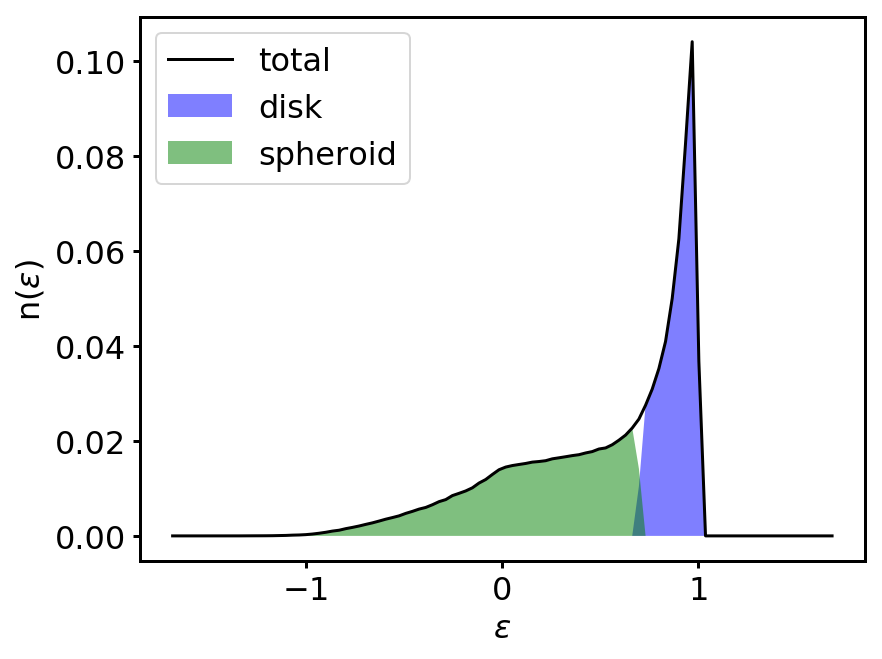

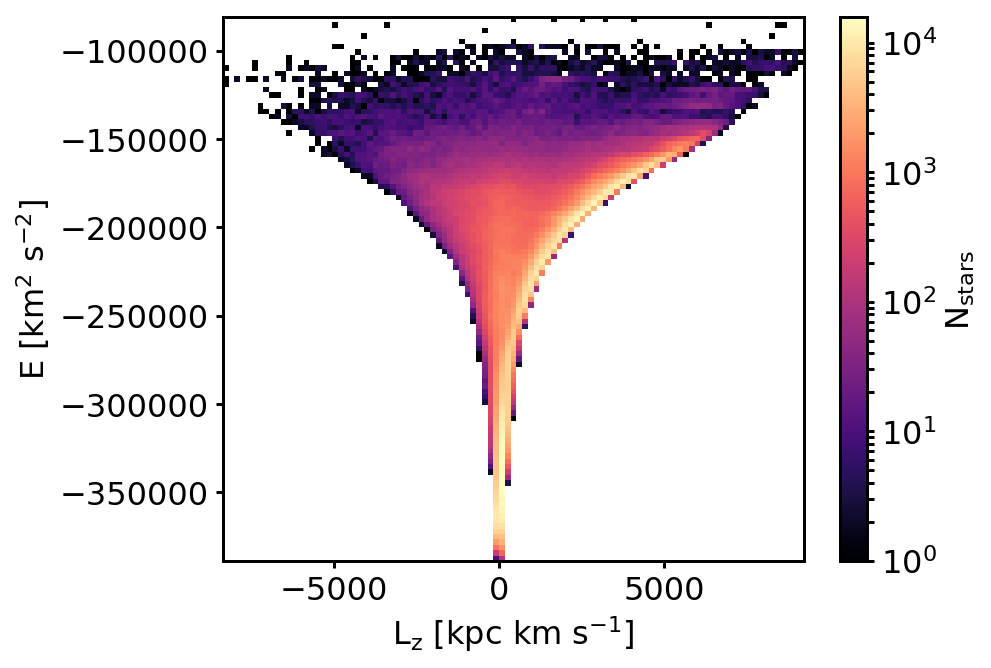

D/T ratio = 0.4710847464285614
[8796164367195 8796298066375 8796134669462 ..., 8796173906367 8796127140798
 8796108562024]
2 (2,)
(array([8796164367195, 8796298066375, 8796134669462, ..., 8796173906367,
       8796127140798, 8796108562024], dtype=uint64), array([8796110281852, 8796168069546, 8796150436993, ..., 8796141499429,
       8796117719020, 8796147129996], dtype=uint64))


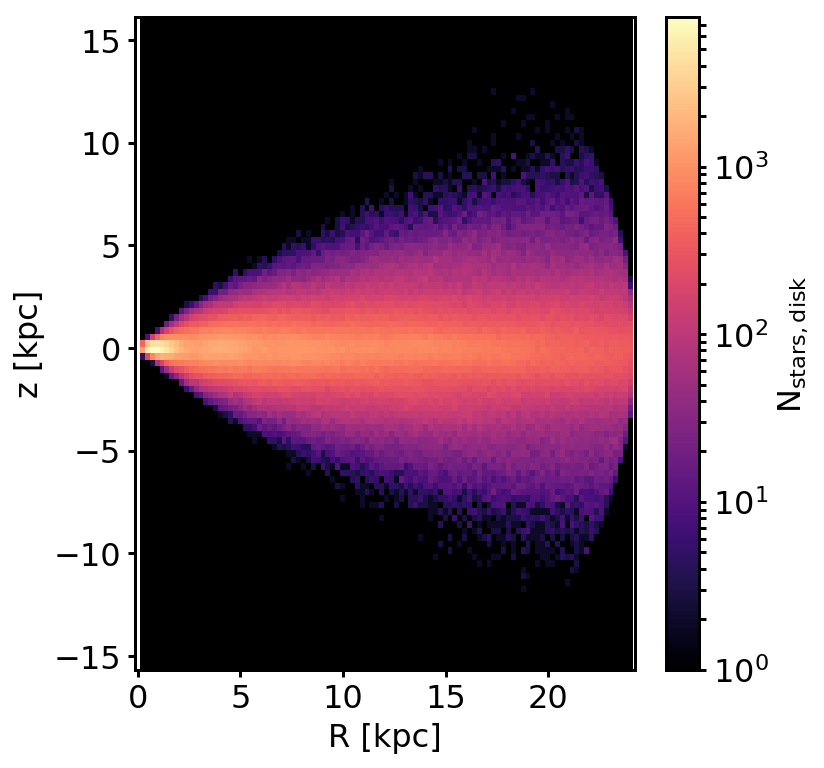

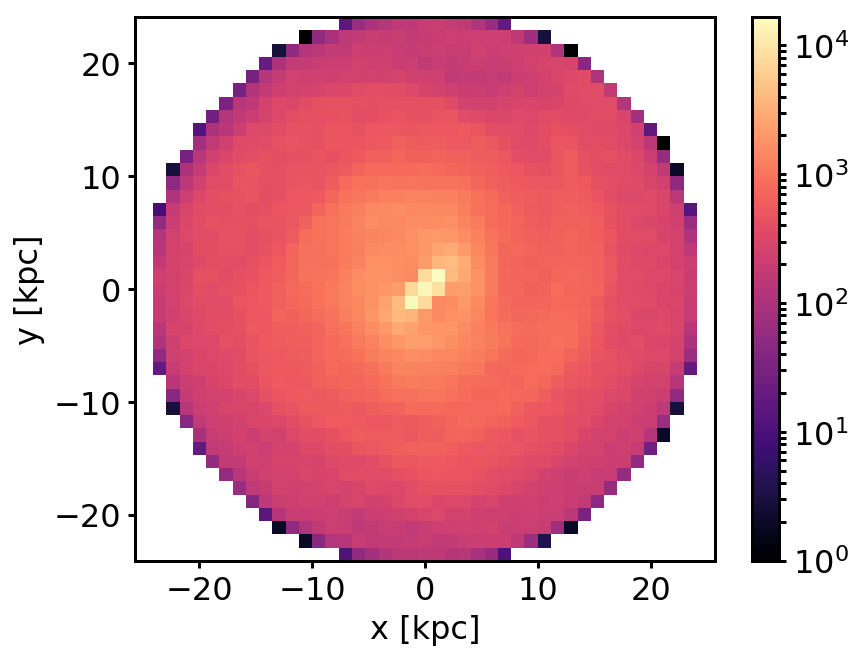

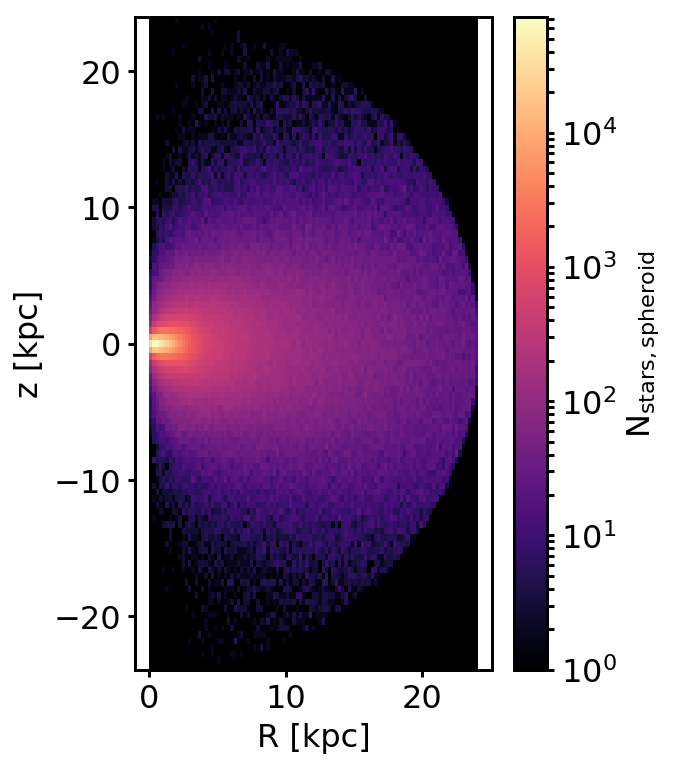

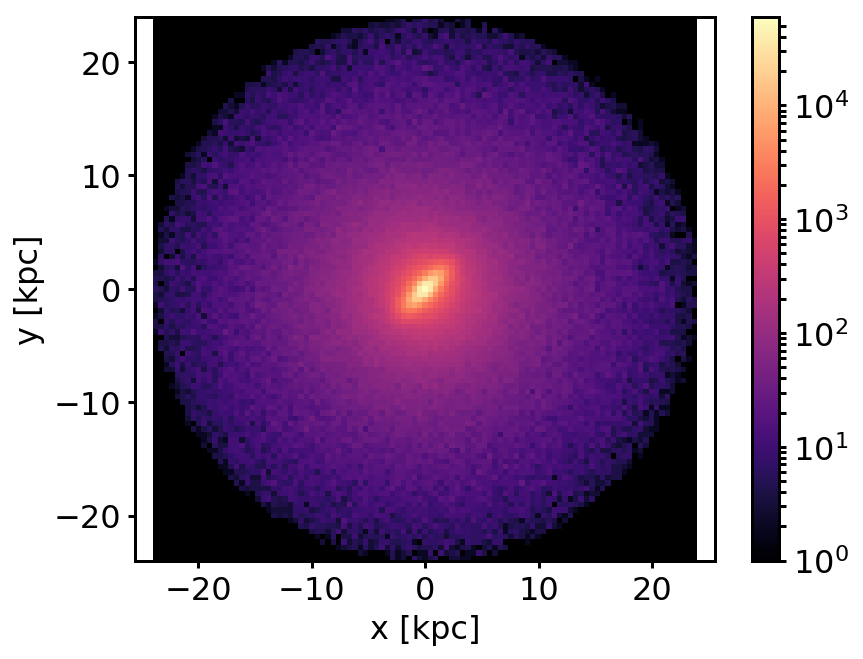

disk mass 3.15149468255179 [10^10M_\odot] 
spheroid mass 3.402557721855875 [10^10M_\odot]
total stellar mas 6.5622590470265205 [10^10M_\odot]
Start MND fit at 00:06:00.256947
/u/milas/conda-envs/auriga/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in true_divide

/u/milas/conda-envs/auriga/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > self.linthresh

/u/milas/conda-envs/auriga/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)



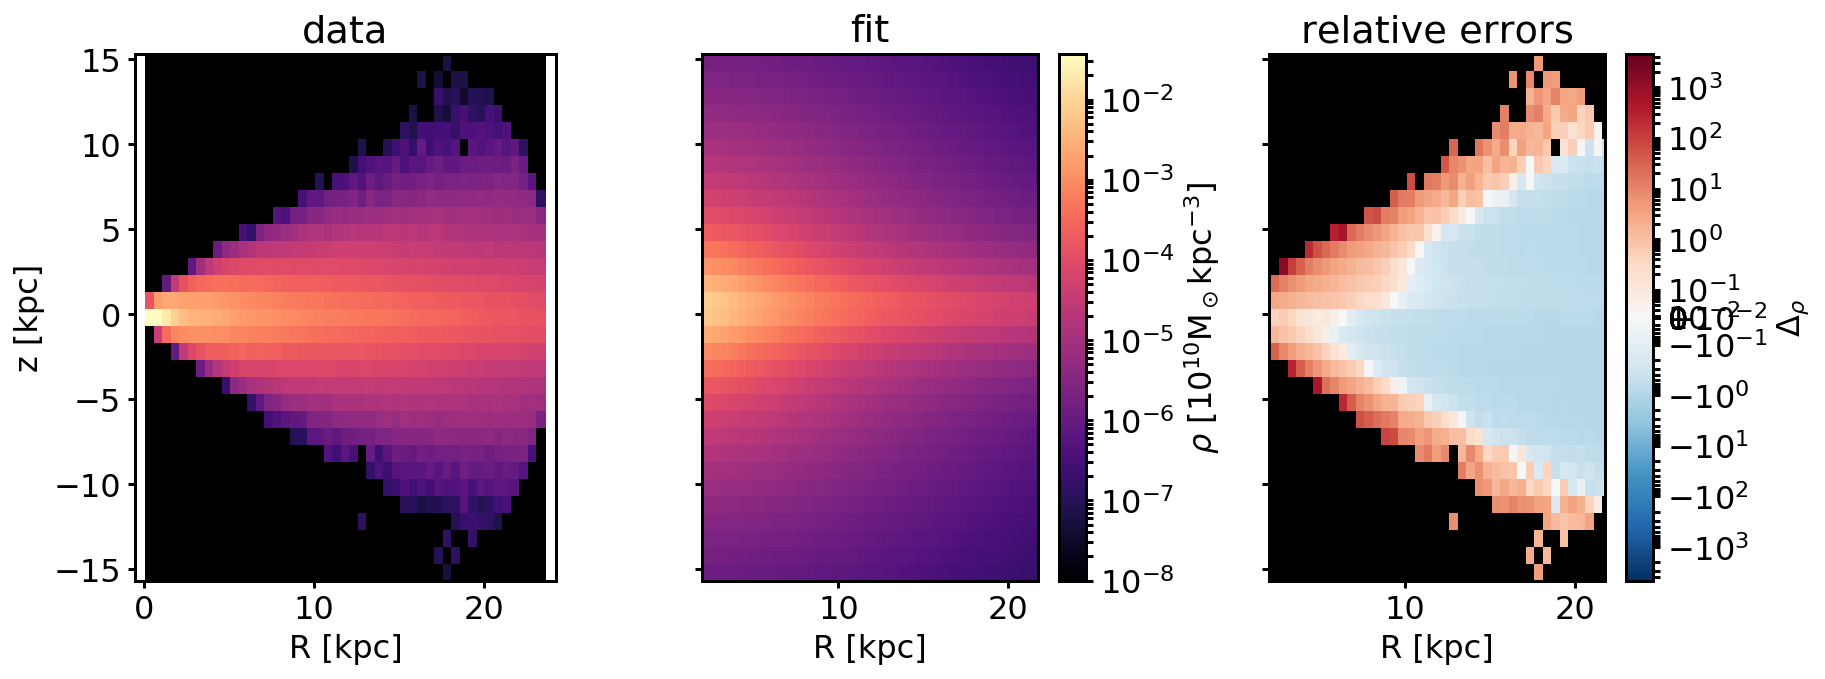

MND: a[kpc], b[kpc], vcirc [km/s]: 2.9650996238 1.63635982048 105.052138758


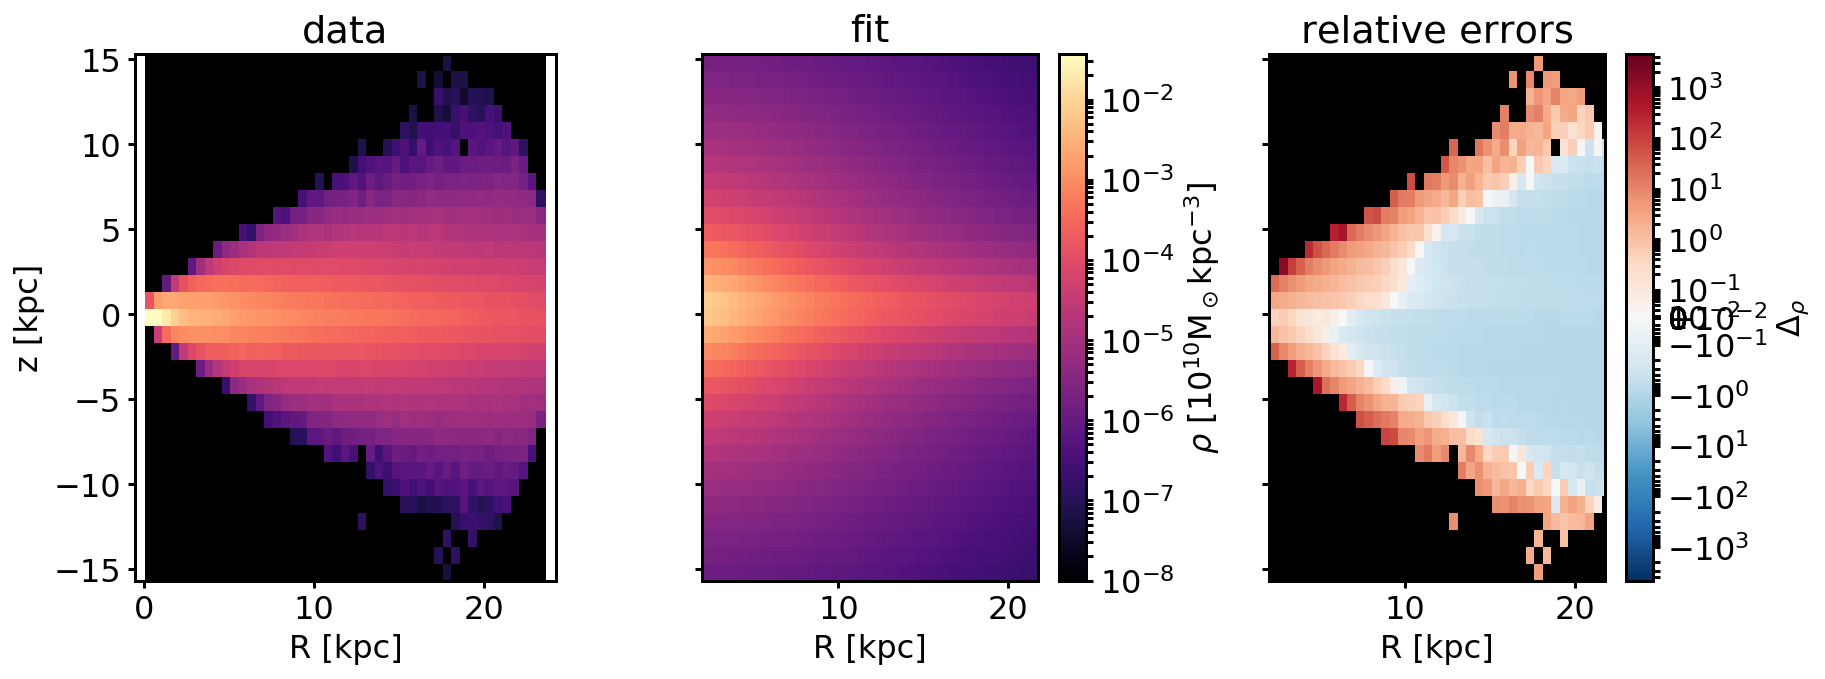

Start HB fit at 00:06:35.339960


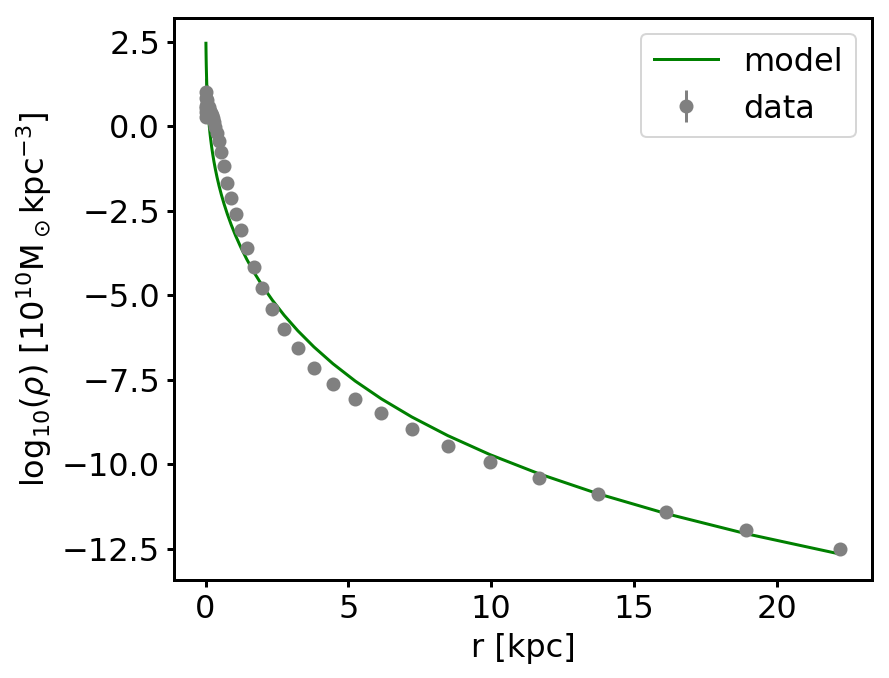

HB: a[kpc], vcirc [km/s]: 1.82638520183 110.113021712


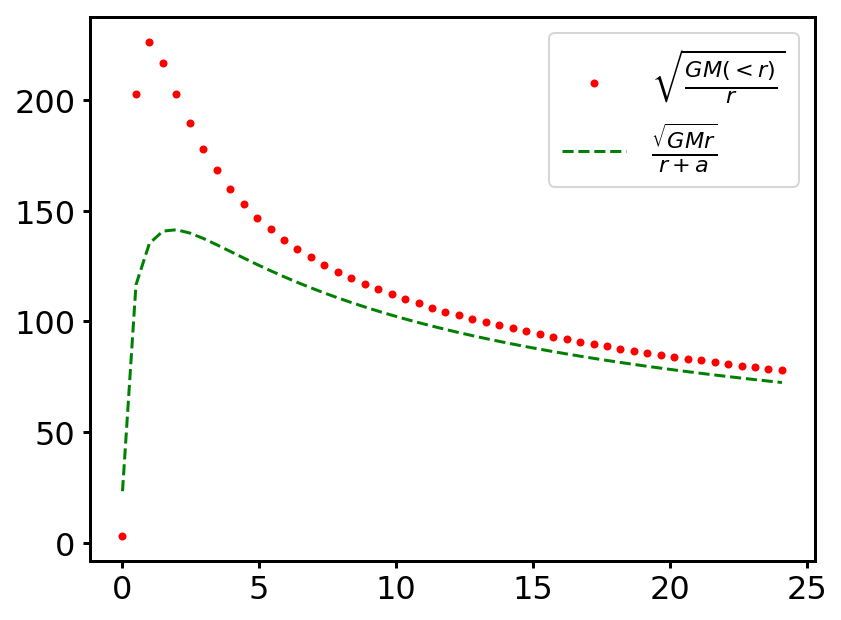

/u/milas/conda-envs/auriga/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]

105.052138758 110.113021712
v0_circ_tot = 212.243196729
computing star properties
computing histograms


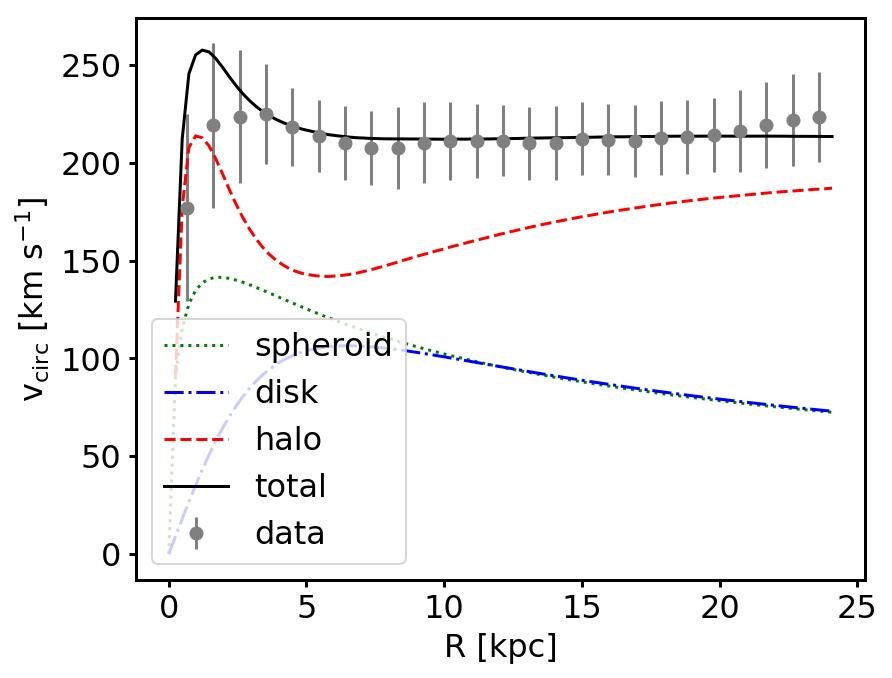

(2.9650996238039942, 1.6363598204793228, 1.8263852018338926, 105.05213875819958, 110.11302171232357, array([  7.70753309,  21.20400993,   8.49326849, ...,   6.09475365,
         2.90106088,  19.73847678]), array([-0.33619596, -0.0636621 ,  3.78197107, ..., -9.26370449,
        1.05500545,  8.41765729]), array([-235965.96875 , -189698.46875 , -224487.6875  , ..., -212473.84375 ,
       -276270.90625 , -185758.421875]), 8.0)


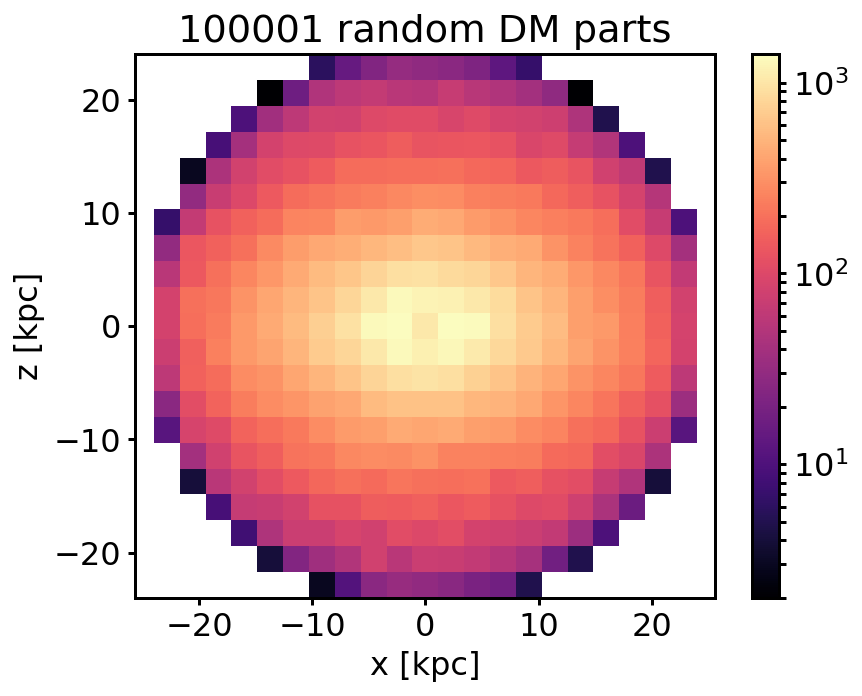

halo comparison from different fitting methods: method 1: [          nan   91.17004635  177.01638623  207.84462179  213.74476293
  212.79397051  208.67929012  202.1121525   194.51947338  186.6401573
  179.16284618  172.32483787  166.42755054  161.22689658  156.88456569
  153.18406303  150.26689176  147.88243702  145.88787559  144.46373433
  143.38345678  142.74071552  142.24261796  141.9535413   141.91708326
  142.16756838  142.52989446  142.97111068  143.57072385  144.39793708
  145.1748225   146.12930053  147.03864262  148.07175625  149.075961
  150.15313349  151.13489408  152.14961664  153.12074889  154.0612848
  155.01407817  155.91327215  156.91473424  157.82502297  158.70762869
  159.60971075  160.48546346  161.3339841   162.22887738  163.09266013
  163.94079566  164.74997284  165.53928731  166.34099881  167.13518671
  167.88737857  168.61450725  169.32757434  170.00176461  170.66141487
  171.3290375   171.997808    172.63618288  173.21496287  173.84136434
  174.42414485  175.020

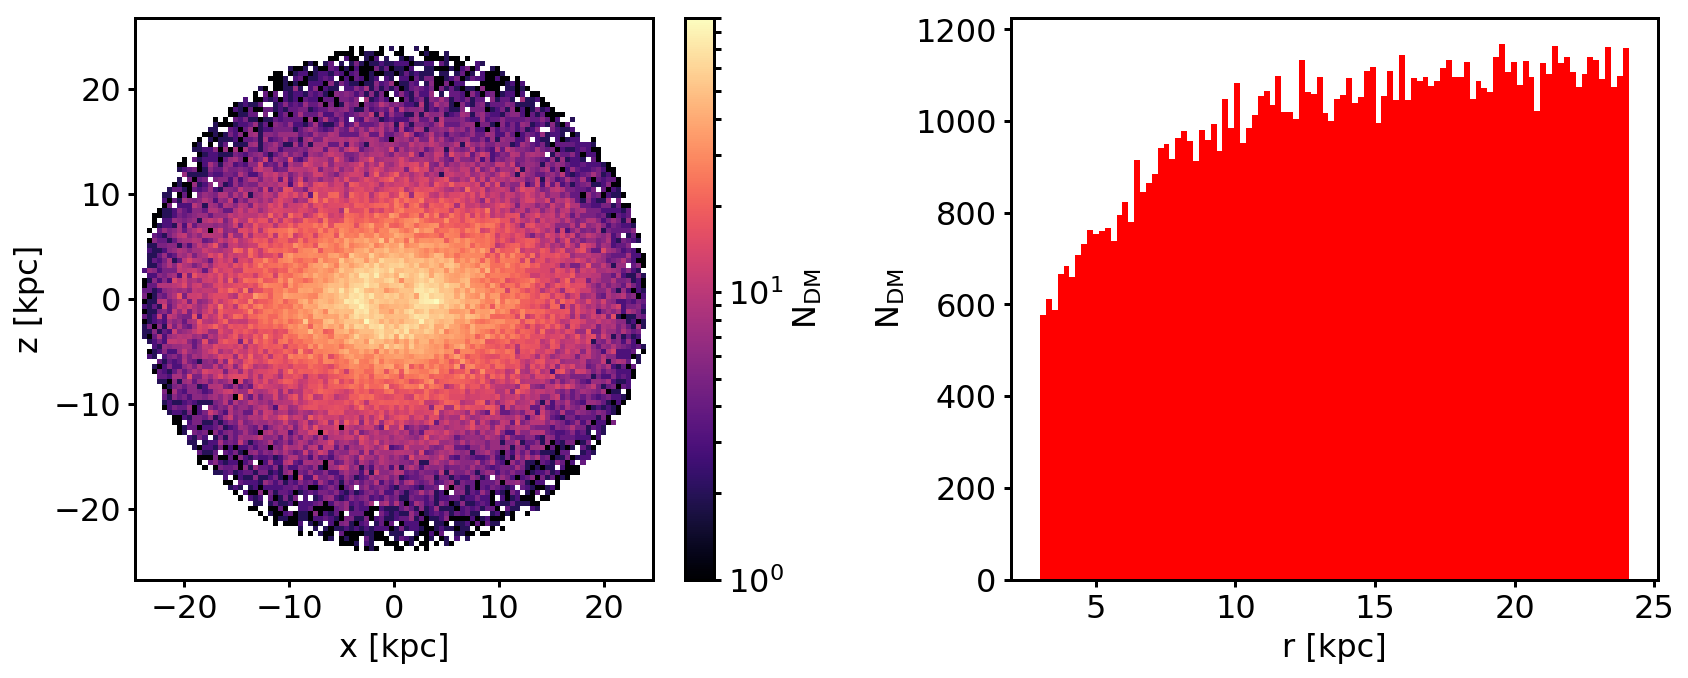

Phi - R abs max <built-in method max of numpy.ndarray object at 0x2b67391f7f30>:
Phi - z abs max <built-in method max of numpy.ndarray object at 0x2b6733207f30>:


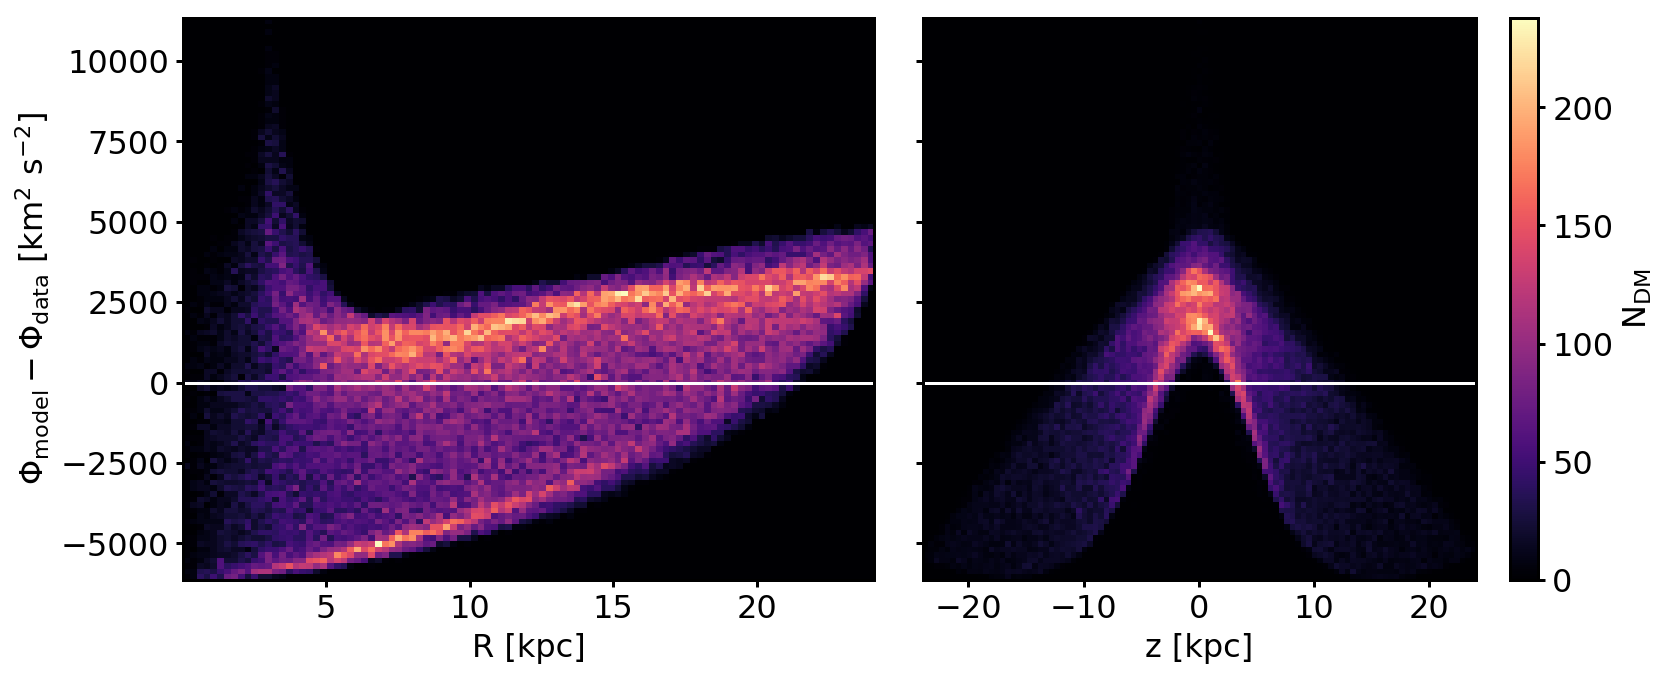

/u/milas/conda-envs/auriga/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "



ValueError: max() arg is an empty sequence

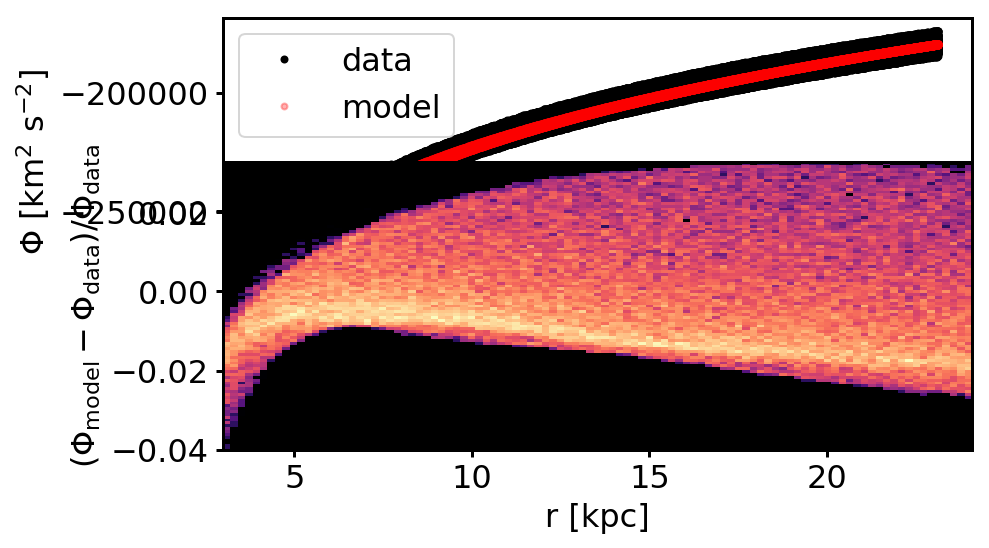

In [10]:
### get everything together somehow 

level = 4
startsnap = 127
endsnap = 128

#j = 0

for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(startsnap,endsnap,1):
        print("snapnr  : {0}".format(snapnr))
        print(datetime.datetime.now().time())
        try:
            s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[1,2,3,4], 
            haloid=0, galradfac=0.1, verbose=True)    
        except KeyError:
            print('\n\n', snapnr, 'not read in.\n\n')
            continue
            
        try: 
            # Clean negative and zero values of gmet to avoid RuntimeErrors
            # later on (e.g. dividing by zero)
            s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
        except:
            continue

            
        Galrad = 1000. * s.galrad
        R0_kpc = 8.
        z0_kpc = 0.
        r0_kpc = R0_kpc
        dr_kpc = 0.5
        
        getIDs = True
        if getIDs == True:
            
            decompobj = decomposition(machine = 'virgo', snapnr = snapnr, use_masses = False, use_n = True, galpyinputfile = None, galpyinputdata = None, have_galpy_potential = False)
            disk_ID, spheroid_ID = decompobj._decomp(circ_val = 0.7, plotter = True, elzplotter= True, savefig = True, include_zmax = False, zmax = 0.001, Gcosmo = 43.0071) 
            np.savetxt(filedir + 'auriga/disk_spheroid_IDs_dec18/spheroid_IDs_snap_{}'.format(snapnr), (spheroid_ID))
            np.savetxt(filedir + 'auriga/disk_spheroid_IDs_dec18/disk_IDs_snap_{}'.format(snapnr), (disk_ID))

        else: 
            disk_ID = np.loadtxt(filedir + 'auriga/disk_spheroid_IDs_dec18/disk_IDs_snap_{}'.format(snapnr), unpack = True)
            spheroid_ID = np.loadtxt(filedir + 'auriga/disk_spheroid_IDs_dec18/spheroid_IDs_snap_{}'.format(snapnr), unpack = True)
        disk_to_total_ratio = len(disk_ID)/(len(disk_ID) + len(spheroid_ID))
        print('D/T ratio = {}'.format(disk_to_total_ratio))
        print(disk_ID)
        data_saved = (disk_ID, spheroid_ID)
        header = 'disk\tspheroid'
        print(len(data_saved), np.shape(data_saved))
        print(data_saved)
        formt = '%d'
        
        ## get data from simulations

        i_stars = np.where( (s.halo == 0) & (s.type == 4) & (s.r() <= s.galrad) & (s.r() > 0.) )
        #j = np.where( s.data[i_stars]['age'] > 0. )
        #i_stars = i_stars[j]
        i_spheroid = np.isin(s.id, spheroid_ID)
        i_disk = np.isin(s.id, disk_ID)
        i_dm = np.where( (s.halo == 0) & ((s.type == 1) + (s.type == 2) + (s.type == 3)) )
        
        galrad_kpc = 1000. * s.galrad
        
        # choice of R_kpc_data and z_kpc_data
        (x_kpc, y_kpc, z_kpc), (vx_kpc, vy_kpc, vz_kpc), rxyz_kpc, rxy_kpc = get_cartesian_vectors(s, sf, i_stars)
        (R_kpc, phi, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, i_stars)
        #print('istars', len(i_stars[0]), 'idisk', np.sum(i_disk), 'i_spher', np.sum(i_spheroid))

        (x_kpc_disk, y_kpc_disk, z_kpc_disk), (vx_kpc_disk, vy_kpc_disk, vz_kpc_disk), rxyz_kpc_disk, rxy_kpc_disk = get_cartesian_vectors(s, sf, i_disk)
        (R_kpc_disk, phi_disk, z_kpc_disk), (vR_kms_disk, vphi_kms_disk, vz_kms_disk) = get_cylindrical_vectors(s, sf, i_disk)
        
        (x_kpc_spher, y_kpc_spher, z_kpc_spher), (vx_kpc_spher, vy_kpc_spher, vz_kpc_spher), rxyz_kpc_spher, rxy_kpc_spher = get_cartesian_vectors(s, sf, i_spheroid)
        (R_kpc_spher, phi_spher, z_kpc_spher), (vR_kms_spher, vphi_kms_spher, vz_kms_spher) = get_cylindrical_vectors(s, sf, i_spheroid)

        
        #R_kpc_data = R_kpc[i_disk][i_stars]
        #z_kpc_data = z_kpc[i_disk][i_stars]
        r_kpc_spher = 1000. * s.r()[i_spheroid]
        #print(np.max(r_kpc))
        
        fig, ax = plt.subplots(figsize=(5.55,6))
        I0 = ax.hist2d(R_kpc_disk, z_kpc_disk, 101, norm=LogNorm(), cmap = cmap)
        cbar = plt.colorbar(I0[3], ax = ax)
        ax.axis('equal')
        ax.set_xlabel('R [kpc]')
        ax.set_ylabel('z [kpc]')
        ax.set_xlim([0, None])
        cbar.set_label('N$_\mathrm{stars, disk}$')
        #fig.tight_layout()
        fig.savefig(plotdir + 'potential/disk_selection_Rz_snap_{}.png'.format(snapnr))
        #ax.title('disk selection')
        plt.show()
        plt.hist2d(x_kpc_disk, y_kpc_disk, 41, norm=LogNorm())
        plt.xlabel('x [kpc]')
        plt.ylabel('y [kpc]')
        plt.axis('equal')
        plt.colorbar()
        plt.show()        
        
        fig, ax = plt.subplots(figsize = (3.7,6))
        I1 = ax.hist2d(R_kpc_spher, z_kpc_spher, 101, norm=LogNorm(), cmap = cmap)
        cbar = plt.colorbar(I1[3], ax = ax)
        ax.axis('equal')
        ax.set_xlabel('R [kpc]')
        ax.set_ylabel('z [kpc]')
        ax.set_xlim([0, None])
        cbar.set_label('N$_\mathrm{stars, spheroid}$')
        #fig.tight_layout()
        fig.savefig(plotdir + 'potential/spheroid_selection_Rz_snap_{}.png'.format(snapnr))
        plt.show()
        plt.hist2d(x_kpc_spher, y_kpc_spher, 101, norm=LogNorm(), cmap = cmap)
        plt.xlabel('x [kpc]')
        plt.ylabel('y [kpc]')
        plt.axis('equal')
        plt.colorbar()
        plt.show()
        
        M_disk_10Msun = s.mass[i_disk]
        M_disk_tot_10Msun = np.sum(s.mass[i_disk])
        M_spher_10Msun = s.mass[i_spheroid]
        M_spher_tot_10Msun = np.sum(s.mass[i_spheroid])
        M_stars_tot_10Msun = np.sum(s.mass[i_stars])
        print('disk mass {} [10^10M_\odot] \nspheroid mass {} [10^10M_\odot]\ntotal stellar mas {} [10^10M_\odot]'.format(M_disk_tot_10Msun, M_spher_tot_10Msun, M_stars_tot_10Msun))
        r_kpc_binned = np.linspace(np.min(r_kpc_spher), np.max(r_kpc_spher), 50)
        #print(r_kpc_binned)
        
        ## fit single parts
        res1 = MND(R_kpc_disk, z_kpc_disk, dR_kpc = 0.5, dz_kpc = 1., M_tot_disk_stars_10Msun = M_disk_tot_10Msun, M_diskstars_10Msun = M_disk_10Msun, R0_kpc = R0_kpc, snapnr = snapnr, z0_kpc = 0.)
        a_MND_kpc, b_MND_kpc, v_circ_MND = res1
        res = fit_dens_MND(R_kpc_disk, z_kpc_disk, dR_kpc = 0.5, dz_kpc = 1., M_tot_disk_stars_10Msun = M_disk_tot_10Msun, M_diskstars_10Msun = M_disk_10Msun, snapnr = snapnr)
        #a_MND_kpc, b_MND_kpc, v_circ_MND = MND(R_kpc_data[i_disk], z_kpc_data[i_disk], M_stars_tot_10Msun, R0_kpc, z0_kpc = 0.)
        a_HB_kpc, v_circ_HB = HB(M_spher_10Msun, r_kpc_spher, dr_kpc, r0_kpc, snapnr)
        v_circ_test1 = HB2(r_kpc_spher, M_spher_10Msun)
        v_circ_test2 = v_circ_HB_func_justr(r_kpc_binned, a_HB_kpc, np.sum(M_spher_10Msun))
        
        plt.plot(r_kpc_binned, v_circ_test1, 'r.', label = '$\sqrt{\\frac{GM(<r)}{r}}$')
        plt.plot(r_kpc_binned, v_circ_test2, 'g--', label = '$\\frac{\sqrt{GMr}}{r+a}$')
        plt.legend()
        plt.show()
        #rot curves
        
        
        #### GUESS OK WITH THE SPHEROID AND DISK FIT 
        
        r_kpc           = np.linspace(0, 1000. * s.galrad, 100)
        v_circ_disk     = v_circ_MND_ab(R_kpc=r_kpc, z_kpc=0., a_MND_kpc=a_MND_kpc, b_MND_kpc=b_MND_kpc, M_tot_10Msun=M_disk_tot_10Msun)
        v_circ_spheroid = v_circ_HB_func_justr(r_kpc, a_HB_kpc, np.sum(M_spher_10Msun))
        v_circ_tot      = v_circ_tot_func(r_kpc=r_kpc)
        v_circ_halo     = v_circ_NFW_func(r_kpc, v_circ_disk, v_circ_spheroid, v_circ_tot)

        
        v0_MND_kms = v_circ_MND_ab(R0_kpc, z0_kpc, a_MND_kpc=a_MND_kpc, b_MND_kpc=b_MND_kpc, M_tot_10Msun=M_disk_tot_10Msun)
        v0_HB_kms  = v_circ_HB_func_justr(R0_kpc, a_HB_kpc, np.sum(M_spher_10Msun))
        print(v0_MND_kms, v0_HB_kms)
        v0_circ_tot = v_circ_tot_func(r_kpc=R0_kpc)
        print('v0_circ_tot =', v0_circ_tot)
        
        # calculate very kinematkally cold particles in disk as data for the circ vel plot
        ID_disk_circ, ID_spher_circ = decompobj._decomp(circ_val = 0.95, include_zmax = True, zmax = 0.005, plotter = False, savefig = False, Gcosmo = 43.0071)
        i_disk_circ= np.isin(s.id, ID_disk_circ)
        (R_circ_stars_kpc, phi_circ_stars_, z_circ_stars_kpc), (vR_circ_stars_kms, vphi_circ_stars_kms, vz_circ_stars_kms) = get_cylindrical_vectors(s, sf, i_disk_circ)

        v_mean_data, v_std_data, R_bins_data = circvel_data(R_circ_stars_kpc, vphi_circ_stars_kms, Galrad, N = 25)
        
        fig, ax = plt.subplots()
        ax.errorbar(R_bins_data, v_mean_data, yerr = v_std_data, fmt = 'o', color = 'grey', label = 'data')
        ax.plot(r_kpc, v_circ_spheroid, 'g:', label = 'spheroid')
        ax.plot(r_kpc, v_circ_disk, 'b-.', label = 'disk')
        ax.plot(r_kpc, v_circ_halo, 'r--',label = 'halo')
        ax.plot(r_kpc, v_circ_tot, 'k-', label = 'total')
        ax.set_xlabel('R [kpc]')
        ax.set_ylabel('$\mathrm{v}_{\mathrm{circ}}$ [km s$^{-1}$]')
        ax.legend()  
        fig.tight_layout()
        #fig.savefig(plotdir + '/potential/best_fit_circular_velocity_via_formula_snap_{}.png'.format(snapnr), format = 'png', dpi = 300, bbox_inches = 'tight')
        plt.show()
        # calculate v_circ NFW
        #v_circ_NFW = v_circ_NFW_func(v_circ_MND, v_circ_HB, R0_kpc)
        #print(v_circ_NFW, v_circ_MND, v_circ_HB)
        #nn = 35
        #R0_ref = r_kpc[nn]
        #print(R0_ref)
        #v0_ref = v_circ_tot[nn]
        #n_NFW  = v_circ_halo[nn]** 2      / v_circ_tot[nn] **2
        #n_HB   = v_circ_spheroid[nn] ** 2 / v_circ_tot[nn] **2
        #n_MND  = v_circ_disk[nn] ** 2     / v_circ_tot[nn] **2
        #print(r_kpc[30], n_NFW + n_HB + n_MND )
        
        part_num = 100001
        
        #i_dm, = np.where( (s.halo == 0) & (s.r() < s.galrad) & (s.r() > 0.) & ((s.type == 1) + (s.type == 2) + (s.type == 3) ))
        # exclude central parts of DM for better fit
        i_dm, = np.where( (s.halo == 0) & (s.r() < s.galrad) & (1000.*s.r() > 3.) & ((s.type == 1) + (s.type == 2) + (s.type == 3) ))


        r_kpc_dm = 1000. * s.r()[i_dm]
        (x_kpc_dm, y_kpc_dm, z_kpc_dm), (vx_kpc_dm, vy_kpc_dm, vz_kpc_dm), rxyz_kpc_dm, rxy_kpc_dm = get_cartesian_vectors(s, sf, i_dm)
        (R_kpc_dm, phi_rad_dm, z_kpc_dm), (vR_kms_dm, vphi_kms_dm, vz_kms_dm) = get_cylindrical_vectors(s, sf, i_dm) 
        pot_kms2_dm = s.pot[i_dm]

        # draw random sample out of data
        try:
            rand_samp = np.array(random.sample(list(enumerate(pot_kms2_dm)), part_num))
            rand_ind = rand_samp[:,0].astype(int)
            pot_kms2_dm_data = rand_samp[:, 1]
            r_kpc_dm_data = r_kpc_dm[rand_ind]
            x_kpc_dm_data = x_kpc_dm[rand_ind]
            R_kpc_dm_data = R_kpc_dm[rand_ind]
            z_kpc_dm_data = z_kpc_dm[rand_ind]
            phi_rad_dm_data = phi_rad_dm[rand_ind]
        except ValueError:        
            pot_kms2_dm_data = pot_kms2_dm
            r_kpc_dm_data = r_kpc_dm
            x_kpc_dm_data = x_kpc_dm
            R_kpc_dm_data = R_kpc_dm
            z_kpc_dm_data = z_kpc_dm
            phi_rad_dm_data = phi_rad_dm
            
        lower_floor = 1e-3
        bounds = ((5./6. * v0_circ_tot, 400.), #REF_V0_kms
                 (lower_floor, 400.)) #a_NFWH
        args = (a_MND_kpc, b_MND_kpc, a_HB_kpc, v0_MND_kms, v0_HB_kms, R_kpc_dm_data, z_kpc_dm_data, pot_kms2_dm_data, R0_kpc)

        print(args)
        plt.hist2d(x_kpc_dm_data, z_kpc_dm_data, 21, norm=LogNorm())
        plt.axis('equal')
        plt.title('{} random DM parts'.format(part_num))
        plt.xlabel('x [kpc]')
        plt.ylabel('z [kpc]')
        plt.colorbar()
        plt.show()
        #plt.hist2d(x_kpc_spher, y_kpc_spher, 21, norm=LogNorm())
        #plt.axis('equal')
        #plt.colorbar()
        #plt.show()

        #fitting:
        res = opt.differential_evolution(
                    rel_pot_error_scipydifferentialevolution,
                    bounds=bounds,
                    args=args,#, MND, HB, NFWH),
                    strategy='best1bin',
                    maxiter=1000,tol=0.01,atol=1e-7,
                    disp=False
                    )
        

        v0_kms_bestfit     = res.x[0]
        a_NFWH_kpc_bestfit = res.x[1]
    
        # make pot plot to see goodness of DM fit

        v0_NFWH_kms = np.sqrt(v0_kms_bestfit**2 - v0_HB_kms**2 - v0_MND_kms**2)
        print('halo comparison from different fitting methods: method 1: {}; method 2:{}'.format(v_circ_halo, v0_NFWH_kms))
        print('total velocity comparison from different fitting methods: method 1: {}; method 2:{}'.format(v_circ_tot, v0_kms_bestfit))


        n_NFWH = v0_NFWH_kms**2 / v0_kms_bestfit**2
        n_HB   = v0_HB_kms**2   / v0_kms_bestfit**2
        n_MND  = v0_MND_kms**2  / v0_kms_bestfit**2
        # setup potential (and check if parameters are physical):
        print('a_MND_kpc = {}\tb_MND_kpc = {}\ta_NFWH_kpc = {}\ta_HB_kpc = {}\tn_MND = {}\tn_NFWH = {}\tn_HB = {}\tR0_kpc'.format(a_MND_kpc, b_MND_kpc, a_NFWH_kpc_bestfit, a_HB_kpc, n_MND, n_NFWH, n_HB, R0_kpc))
        try:
            pot_galpy_model = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc_bestfit, a_HB_kpc, n_MND, n_NFWH, n_HB, R0_kpc) #
        except Exception as e:
            print("eroorrrr")


        pot_kms2_model = evaluatePotentials(pot_galpy_model,
                                       R_kpc_dm_data / R0_kpc,
                                       z_kpc_dm_data / R0_kpc) * (v0_kms_bestfit)**2
        fig, ax = plt.subplots(1,2, figsize = (12,5))
        im0 = ax[0].hist2d(x_kpc_dm_data,z_kpc_dm_data, bins = 100, norm = LogNorm())
        ax[0].set_xlabel('x [kpc]')
        ax[0].set_ylabel('z [kpc]')
        cbar0 = plt.colorbar(im0[3], ax = ax[0])
        cbar0.set_label('N$_{\mathrm{DM}}$')
        ax[0].axis('equal')
        im1 = ax[1].hist(r_kpc_dm_data, bins = 100, color = 'red')
        ax[1].set_xlabel('r [kpc]')
        ax[1].set_ylabel('N$_{\mathrm{DM}}$')
        fig.tight_layout()
        fig.savefig(plotdir + '/potential/DM_selected_part_dist_snap_{}.png'.format(snapnr), format = 'png', dpi = 300, bbox_inches = 'tight')
        plt.show()
    
        abs_diff_dm = pot_kms2_model - pot_kms2_dm_data
        rel_diff_dm = abs_diff_dm/pot_kms2_dm_data
        
        res1 = stats.binned_statistic_2d(R_kpc_dm_data, abs_diff_dm, None, statistic = 'count', bins = 101)
        res2 = stats.binned_statistic_2d(z_kpc_dm_data, abs_diff_dm, None, statistic = 'count', bins = 101)

        vmax1 = np.max(res1.statistic)
        vmax2 = np.max(res2.statistic) 
        if vmax1>vmax2:
            vmax = vmax1
        elif vmax2>vmax1:
            vmax = vmax2
        else: vmax = vmax1    

        fig, ax = plt.subplots(1,2, sharey = True, figsize = (12,5))
        I0 = ax[0].hist2d(R_kpc_dm_data, abs_diff_dm, bins = 101, vmax = vmax, norm = LogNorm(), cmap =cmap)
        #cbar0 = ax[0].colorbar(I0[3])
        ax[0].set_ylabel('$\Phi_\mathrm{model} - \Phi_\mathrm{data}$ [km$^2$ s$^{-2}$]')
        ax[0].set_xlabel('R [kpc]')
        ax[0].axhline(0, color = 'white', linewidth = 1.5)
        I1 = ax[1].hist2d(z_kpc_dm_data, abs_diff_dm, bins = 101, vmax = vmax, norm = LogNorm(), cmap =cmap)
        cbar1 = plt.colorbar(I1[3], ax = ax[1])
        cbar1.set_label('N$_\mathrm{DM}$')
        #ax.ylabel('$\Phi_\mathrm{model} - \Phi_\mathrm{data}$')
        ax[1].axhline(0, color = 'white', linewidth = 1.5)
        ax[1].set_xlabel('z [kpc]')
        fig.tight_layout()
        fig.savefig(plotdir + '/potential/total_phi_error_snap_{}.png'.format(snapnr), format = 'png', dpi = 300, bbox_inches = 'tight')
        plt.show()
        
        #fig, ax = plt.subplots(2,1, figsize = (6.5,6), sharex = True)
        fig = plt.figure(figsize = (6,7))
        ax1 = fig.add_axes([0.15, 0.3, 0.64, 0.5],xticklabels=[])
        ax2 = fig.add_axes([0.15, 0.1, 0.8, 0.2],)        
        ax1.plot(r_kpc_dm_data, pot_kms2_dm_data, 'k.', label = 'data')
        ax1.plot(r_kpc_dm_data, pot_kms2_model, '.', color = 'red', label = 'model', alpha = 0.3)
        ax1.set_xlim(np.min(r_kpc_dm_data), np.max(r_kpc_dm_data))
        ax1.legend()
        ax1.set_ylabel('$\Phi$ [km$^2$ s$^{-2}$]')
        I2 = ax2.hist2d(r_kpc_dm_data, rel_diff_dm, bins = 101, cmap = cmap, norm = LogNorm())
        cbar2 = plt.colorbar(I2[3], ax = ax2)
        cbar2.set_label('N$_\mathrm{DM}$')
        ax2.set_ylabel('$\Delta_\mathrm{rel}\Phi$')
        ax2.set_xlabel('r [kpc]')
        ax2.get_yaxis().set_label_coords(-0.3,0.5)

        ax2.axhline(0, color = 'white', linewidth = 1.5)
        #fig.tight_layout()
        fig.savefig(plotdir + '/potential/phi_model_and_data_snap_with_rel_error_{}.png'.format(snapnr), format = 'png', dpi = 300, bbox_inches = 'tight')
        plt.show()
        

        
        fig, axes = plt.subplots(1,3, sharey = True, figsize = (18,5))
        axes[0].plot(R_kpc_dm_data, rel_diff_dm, '.', color = 'red')
        axes[0].set_ylabel('$\\frac{\Phi_\mathrm{model} - \Phi_\mathrm{data}}{\Phi_\mathrm{data}}$')
        axes[0].set_xlabel('R [kpc]')
        axes[0].axhline(0, color = 'black', linewidth = 1.5)
        axes[1].plot(z_kpc_dm_data, rel_diff_dm, '.', color = 'red')
        #ax.ylabel('$(\Phi_\mathrm{model} - \Phi_\mathrm{data})/\Phi_\mathrm{data})$')
        axes[1].set_xlabel('z [kpc]')
        axes[1].axhline(0, color = 'black', linewidth = 1.5)
        axes[2].plot(phi_rad_dm_data, rel_diff_dm, '.', color = 'red')
        #ax.ylabel('$(\Phi_\mathrm{model} - \Phi_\mathrm{data})/\Phi_\mathrm{data})$')
        axes[2].axhline(0, color = 'black', linewidth = 1.5)
        axes[2].set_xlabel('phi [rad]')
        fig.tight_layout()
        fig.savefig(plotdir + '/potential/rel_phi_error_snap_{}.png'.format(snapnr), format = 'png', dpi = 300, bbox_inches = 'tight')
        plt.show()
        # save data 
        
        data_saved = np.array([snapnr, R0_kpc, v0_kms_bestfit, a_MND_kpc, b_MND_kpc, a_HB_kpc, a_NFWH_kpc_bestfit, v0_MND_kms, v0_HB_kms, v0_NFWH_kms])
        print(len(data_saved), np.shape(data_saved))
        print(data_saved)
        formt = '%3.12f'
        
        np.savetxt(filedir + 'potential/potential_params_dec18/pot_snap_{}'.format(snapnr), data_saved, fmt = formt)
        print('Snapshot = ', snapnr)
        print('v0_tot_kms at R0_kpc =', R0_kpc, ':', v0_kms_bestfit)
        print('Stellar Disk - a_MND_kpc =', a_MND_kpc, 'b_MND_kpc =', b_MND_kpc, 'v0_MND_kms =', v0_MND_kms)
        print('Stellar Spheroid - a_HB_kp c=', a_HB_kpc, 'v0_HB_kms =', v0_HB_kms)
        print('DM Halo - a_NFWH_kpc =', a_NFWH_kpc_bestfit, 'v0_NFWH_kms =', v0_NFWH_kms)



Phi - R abs max 73.0:
Phi - z abs max 238.0:


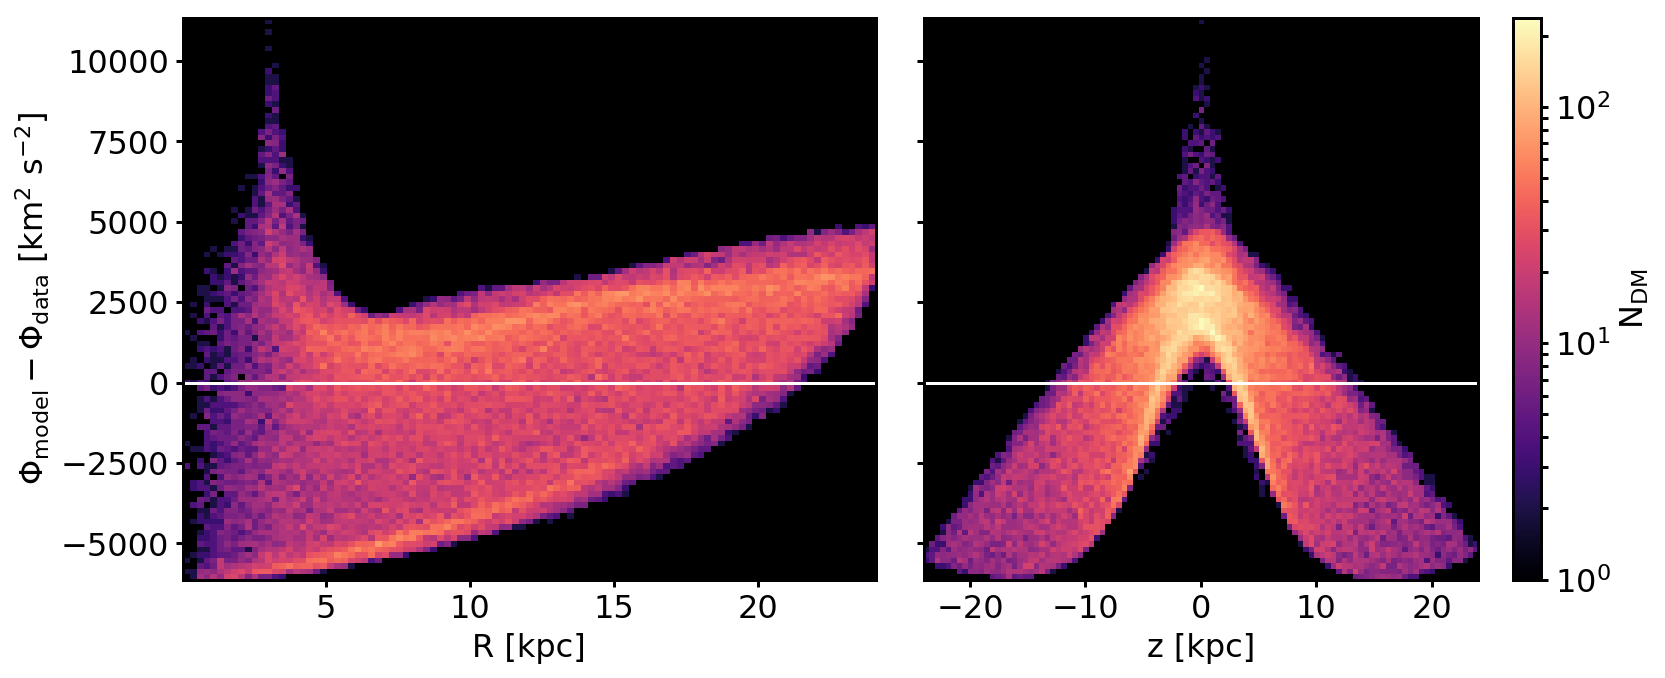

In [27]:
res1 = stats.binned_statistic_2d(R_kpc_dm_data, abs_diff_dm, None, statistic = 'count', bins = 101)
res2 = stats.binned_statistic_2d(z_kpc_dm_data, abs_diff_dm, None, statistic = 'count', bins = 101)

vmax1 = np.max(res1.statistic)
vmax2 = np.max(res2.statistic) 
if vmax1>vmax2:
    vmax = vmax1
elif vmax2>vmax1:
    vmax = vmax2
else: vmax = vmax1    

fig, ax = plt.subplots(1,2, sharey = True, figsize = (12,5))
I0 = ax[0].hist2d(R_kpc_dm_data, abs_diff_dm, bins = 101, vmax = vmax, norm = LogNorm(), cmap =cmap)
#cbar0 = ax[0].colorbar(I0[3])
ax[0].set_ylabel('$\Phi_\mathrm{model} - \Phi_\mathrm{data}$ [km$^2$ s$^{-2}$]')
ax[0].set_xlabel('R [kpc]')
ax[0].axhline(0, color = 'white', linewidth = 1.5)
I1 = ax[1].hist2d(z_kpc_dm_data, abs_diff_dm, bins = 101, vmax = vmax, norm = LogNorm(), cmap =cmap)
cbar1 = plt.colorbar(I1[3], ax = ax[1])
cbar1.set_label('N$_\mathrm{DM}$')
#ax.ylabel('$\Phi_\mathrm{model} - \Phi_\mathrm{data}$')
ax[1].axhline(0, color = 'white', linewidth = 1.5)
ax[1].set_xlabel('z [kpc]')
fig.tight_layout()
fig.savefig(plotdir + '/potential/total_phi_error_snap_{}.png'.format(snapnr), format = 'png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5.55,6))
I0 = ax.hist2d(R_kpc_disk, z_kpc_disk, 101, norm=LogNorm(), cmap = cmap)
cbar = plt.colorbar(I0[3], ax = ax)
ax.axis('equal')
ax.set_xlabel('R [kpc]')
ax.set_ylabel('z [kpc]')
ax.set_xlim([0, None])
cbar.set_label('N$_\mathrm{stars, disk}$')
#fig.tight_layout()
fig.savefig(plotdir + 'potential/disk_selection_Rz_snap_{}.png'.format(snapnr))
#ax.title('disk selection')
plt.show()
     

fig, ax = plt.subplots(figsize = (3.7,6))
I1 = ax.hist2d(R_kpc_spher, z_kpc_spher, 101, norm=LogNorm(), cmap = cmap)
cbar = plt.colorbar(I1[3], ax = ax)
ax.axis('equal')
ax.set_xlabel('R [kpc]')
ax.set_ylabel('z [kpc]')
ax.set_xlim([0, None])
cbar.set_label('N$_\mathrm{stars, spheroid}$')
#fig.tight_layout()
fig.savefig(plotdir + 'potential/spheroid_selection_Rz_snap_{}.png'.format(snapnr))
plt.show()



In [ ]:
v0_NFWH_kms = np.sqrt(v0_kms_bestfit**2 - v0_HB_kms**2 - v0_MND_kms**2)
print('v0_tot_kms at R0_kpc =', R0_kpc, ':', v0_kms_bestfit)
print('Stellar Disk - a_MND_kpc =', a_MND_kpc, 'b_MND_kpc =', b_MND_kpc, 'v0_MND_kms =', v0_MND_kms)
print('Stellar Spheroid - a_HB_kp c=', a_HB_kpc, 'v0_HB_kms =', v0_HB_kms)
print('DM Halo - a_NFWH_kpc =', a_NFWH_kpc_bestfit, 'v0_NFWH_kms =', v0_NFWH_kms)


In [ ]:
v0_NFWH_kms = np.sqrt(v0_kms_bestfit**2 - v0_HB_kms**2 - v0_MND_kms**2)
print('v0_tot_kms at R0_kpc =', R0_kpc, ':', v0_kms_bestfit)
print('Stellar Disk - a_MND_kpc:', a_MND_kpc, 'b_MND_kpc:', b_MND_kpc, 'v0_MND_kms:', v0_MND_kms)
print('Stellar Spheroid - a_HB_kpc:', a_HB_kpc, 'v0_HB_kms:', v0_HB_kms)
print('DM Halo - a_NFWH_kpc:', a_NFWH_kpc_bestfit, 'v0_NFWH_kms:', v0_NFWH_kms)


In [ ]:
n_NFW = v_circ_halo[35] ** 2 / v_circ_tot[35] **2
n_HB = v_circ_spheroid[35] ** 2 / v_circ_tot[35] **2
n_MND = v_circ_disk[35] ** 2 / v_circ_tot[35] **2
print(r_kpc[65], n_NFW + n_HB + n_MND )

In [ ]:

v_circ_NFW = v_circ_NFW_func(v_circ_MND, v_circ_HB, R0_kpc)
print(v_circ_NFW, v_circ_MND, v_circ_HB)
print(np.sqrt(v_circ_NFW**2 + v_circ_HB**2 + v_circ_MND**2))

In [ ]:
a_HB_kpc

In [ ]:
print(a_MND_kpc, b_MND_kpc, a_HB_kpc
     )

In [ ]:
plt.plot(r_kpc, v_circ_spheroid, 'k.', label = 'spheroid')
plt.plot(r_kpc, v_circ_disk, 'g-', label = 'disk')
plt.plot(r_kpc, v_circ_halo, 'r--', label = 'halo')
plt.plot(r_kpc, v_circ_tot, 'b-.', label = 'total')
plt.xlabel('R [kpc]')
plt.ylabel('$v_{circ} \ [km/s]$')
plt.legend()

In [ ]:
dmhalo0 = np.where((s.halo == 0) * (s.subhalo ==0) * ((s.type == 1) + (s.type == 2) + (s.type ==3)))

r_kpc_dm0 = 1000. * s.r()[dmhalo0]
(x_kpc_dm0, y_kpc_dm0, z_kpc_dm0), (vx_kpc_dm0, vy_kpc_dm0, vz_kpc_dm0), rxyz_kpc_dm0, rxy_kpc_dm0 = get_cartesian_vectors(s, sf, dmhalo0)
(R_kpc_dm0, phi_rad_dm0, z_kpc_dm0), (vR_kms_dm0, vphi_kms_dm0, vz_kms_dm0) = get_cylindrical_vectors(s, sf, dmhalo0) 
pot_kms2_dm0 = s.pot[dmhalo0]


In [ ]:
plt.hist2d(R_kpc_dm0, z_kpc_dm0, bins = 100)
plt.axis('equal')
plt.show()

In [ ]:
plt.hist2d(x_kpc_dm_data,z_kpc_dm_data, bins = 100, norm = LogNorm())
plt.axis('equal')
plt.show()

In [ ]:
level = 4

j = 0
startsnap = 127
endsnap = 128
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(startsnap,endsnap,1):
        #print("level   : {0}".format(level))
        #print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print(datetime.datetime.now().time())
        #print("basedir : {0}".format(basedir))
        #print("halodir : {0}".format(halodir))
        #print("snappath: {0}\n".format(snappath))
        try:
            s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[1,2,3,4], 
            haloid=0, galradfac=0.1, verbose=False, rotate_disk=False, do_rotation=False, use_principal_axis=False) 
        except KeyError:
            print('\n\n', snapnr, 'not read in.\n\n')
            continue

            

In [ ]:
def potential_fit(maxr_Mpc, _REFR0_kpc = 8., mask_num = 2, part_num = 1501, \
                  v0_kms_init = 150., a_MND_kpc_init = 6., b_MND_kpc_init = 1., \
                  a_NFWH_kpc_init = 10., a_HB_kpc_init = 2., n_MND_init = 0.2, n_NFWH_init = 0.6, \
                  fitroutine = 'emcee', nwalkers = 50, nstep = 1000, \
                  comp_mask = None, MND = True, HB = True, NFWH = True, \
                  grav_rad_HB_kpc = 2., \
                  res_arr = [], plot = False, verbose = False):
    
    if comp_mask is None:   
        ### selection masks
        # select ALL particles belonging to the main galaxy within maxr
        if mask_num == 0:
            mask, = np.where( (s.halo == 0) & (s.r() < maxr_Mpc) & (s.r() > 0.) )
            parts_to_fit = 'all'
        # select GAS particles belonging to the main galaxy within maxr
        if mask_num == 1:
            mask, = np.where( (s.halo == 0) & (s.r() < maxr_Mpc) & (s.r() > 0.) & (s.type == 0) )
            parts_to_fit = 'gas'
        # select DM particles belonging to the main galaxy within maxr
        if mask_num == 2:
            mask, = np.where( (s.halo == 0) & (s.r() < maxr_Mpc) & (s.r() > 0.) & ((s.type == 1) + (s.type == 2) + (s.type == 3) ))
            parts_to_fit = 'DM'
        # select STAR particles belonging to the main galaxy within maxr
        if mask_num == 3:
            mask, = np.where( (s.halo == 0) & (s.r() < maxr_Mpc) & (s.r() > 0.) & (s.type == 4) )
            parts_to_fit = 'star'

        if verbose == True:
            print('The potential is fitted to ' + str(part_num) + ' random selected ' + parts_to_fit + ' particles.')

        # select data with mask
        r_kpc = 1000. * s.r()[mask]
        (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, mask) 
        pot_kms2 = s.pot[mask]

        # draw random sample out of data
        try:
            rand_samp = np.array(random.sample(list(enumerate(pot_kms2)), part_num))
            rand_ind = rand_samp[:,0].astype(int)
            pot_kms2_data = rand_samp[:, 1]
            r_kpc_data = r_kpc[rand_ind]
            R_kpc_data = R_kpc[rand_ind]
            z_kpc_data = z_kpc[rand_ind]
        except ValueError:        
            pot_kms2_data = pot_kms2
            r_kpc_data = r_kpc
            R_kpc_data = R_kpc
            z_kpc_data = z_kpc
            
    else:
        mask = comp_mask
        ## check that the right IDs are selected
        if (MND == 1) * (HB == 1) * (NFWH == 1):
            if np.sum((s.type[mask] == 1) + (s.type[mask] == 2) + (s.type[mask] == 3) + (s.type[mask] == 4)) != np.sum(mask):
                raise ValueError('IDs might be chosen wrong.')
        elif (MND == 1) * (HB == 1) * (NFWH == 0):
            if np.sum(np.where(s.type[mask] != 4)) != 0:
                raise ValueError('IDs might be chosen wrong.')            
        elif (MND == 1) * (HB == 0) * (NFWH == 1):
            if np.sum((s.type[mask] == 1) + (s.type[mask] == 2) + (s.type[mask] == 3) + (s.type[mask] == 4)) != np.sum(mask):
                raise ValueError('IDs might be chosen wrong.')            
        elif (MND == 0) * (HB == 1) * (NFWH == 1):
            if np.sum((s.type[mask] == 1) + (s.type[mask] == 2) + (s.type[mask] == 3) + (s.type[mask] == 4)) != np.sum(mask):
                raise ValueError('IDs might be chosen wrong.')           
        elif (MND == 1) * (HB == 0) * (NFWH == 0):
            if np.sum(np.where(s.type[mask] != 4)) != 0:
                raise ValueError('IDs might be chosen wrong.')
        elif (MND == 0) * (HB == 1) * (NFWH == 0):
            if np.sum(np.where(s.type[mask] != 4)) != 0:
                raise ValueError('IDs might be chosen wrong.')          
        elif (MND == 0) * (HB == 0) * (NFWH == 1):
            if np.sum((s.type[mask] == 1) + (s.type[mask] == 2) + (s.type[mask] == 3)) != np.sum(mask):
                raise ValueError('IDs might be chosen wrong.')
        
        if (MND == 0) * (HB == 1) * (NFWH == 0):
            mask = np.where(((1000. * s.r()[comp_mask]) < grav_rad_HB_kpc))
        
        r_kpc = 1000. * s.r()[mask]
        (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, mask) 
        pot_kms2 = s.pot[mask] 
        pot_kms2_data = pot_kms2
        r_kpc_data = r_kpc
        R_kpc_data = R_kpc
        z_kpc_data = z_kpc
                    

    if fitroutine == 'emcee': # maybe implement diff ev but not now
        # _____prepare MCMC_____
        ndim, nwalkers, nstep = 7, nwalkers, nstep

        # initial values for fit:
        # init values as input of function
        initial_guess = np.array([v0_kms_init, a_MND_kpc_init, b_MND_kpc_init, a_NFWH_kpc_init, \
                                  a_HB_kpc_init, n_MND_init, n_NFWH_init])
        initial_guess_width = np.fabs(0.2 * initial_guess)
        p0 = np.array([np.random.randn(ndim) * np.array(initial_guess_width) + initial_guess \
                                                      for i in range(nwalkers)])
        # fiitting boundaries:
        boundaries = np.array([[0.,np.inf],[0.,np.inf],[0.,np.inf],[0.,np.inf],[0.,np.inf],[0.,1.],[0.,1.]])
        for pp in range(ndim):
            p0[(p0[:,pp] < boundaries[pp,0]),pp] = initial_guess[pp] + np.random.uniform() * 0.1
            p0[(p0[:,pp] > boundaries[pp,1]),pp] = initial_guess[pp] - np.random.uniform() * 0.1

        # _____run MCMC_____
        sampler = emcee.EnsembleSampler(nwalkers, ndim,
                                       lnprob_MCMC,
                                       args = [R_kpc_data, z_kpc_data, pot_kms2_data, _REFR0_kpc])
        sampler.run_mcmc(p0, nstep)

        # result:
        burnin = int(nwalkers / 2.) # check what this is used for. #1000
        final_samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
        chain_samples = sampler.chain

        median = np.median(final_samples,axis=0)
        std = np.std(final_samples,axis=0)

        v0_kms_bestfit     = median[0]
        a_MND_kpc_bestfit  = median[1]
        b_MND_kpc_bestfit  = median[2]
        a_NFWH_kpc_bestfit = median[3]
        a_HB_kpc_bestfit   = median[4]
        n_MND_bestfit      = median[5]
        n_NFWH_bestfit     = median[6]
        n_HB_bestfit       = 1. - (n_MND_bestfit + n_NFWH_bestfit)

        v0_kms_bestfit_err     = std[0]
        a_MND_kpc_bestfit_err  = std[1]
        b_MND_kpc_bestfit_err  = std[2]
        a_NFWH_kpc_bestfit_err = std[3]
        a_HB_kpc_bestfit_err   = std[4]
        n_MND_bestfit_err      = std[5]
        n_NFWH_bestfit_err     = std[6]
        n_HB_bestfit_err       = (n_MND_bestfit_err + n_NFWH_bestfit_err)

        
        
        # save potential parameters with errors and snapnr:
        pot_bestfit = np.array([v0_kms_bestfit, v0_kms_bestfit_err, a_MND_kpc_bestfit, a_MND_kpc_bestfit_err, \
                            b_MND_kpc_bestfit, b_MND_kpc_bestfit_err, a_NFWH_kpc_bestfit, a_NFWH_kpc_bestfit_err, \
                            a_HB_kpc_bestfit, a_HB_kpc_bestfit_err, n_MND_bestfit, n_MND_bestfit_err, \
                            n_NFWH_bestfit, n_NFWH_bestfit_err, n_HB_bestfit, n_HB_bestfit_err])
        
        res_arr = np.append(res_arr, pot_bestfit)
    
    elif fitroutine == 'diffev':
        lower_floor = 1e-3
        bounds = ((lower_floor,400.), #vcirc
                  (lower_floor,500.), #a_MND
                  (lower_floor,100.), #b_MND
                  (lower_floor,500.), #a_NFWH
                  (lower_floor,500.), #a_HB
                  (0., 1.), #n_MND
                  (0., 1.)) #n_NFWH

        #fitting:
        res = opt.differential_evolution(
                    rel_pot_error_scipydifferentialevolution,
                    bounds=bounds,
                    args=(R_kpc_data,z_kpc_data,pot_kms2_data, _REFR0_kpc, MND, HB, NFWH),
                    strategy='best1bin',
                    maxiter=1000,tol=0.01,atol=1e-7,
                    disp=False
                    )
        
        v0_kms_bestfit     = res.x[0]
        a_MND_kpc_bestfit  = res.x[1]
        b_MND_kpc_bestfit  = res.x[2]
        a_NFWH_kpc_bestfit = res.x[3]
        a_HB_kpc_bestfit   = res.x[4]
        n_MND_bestfit      = res.x[5]
        n_NFWH_bestfit     = res.x[6]
        n_HB_bestfit       = 1. - (n_MND_bestfit + n_NFWH_bestfit)


        pot_bestfit = np.array([v0_kms_bestfit, a_MND_kpc_bestfit, b_MND_kpc_bestfit, a_NFWH_kpc_bestfit, \
                            a_HB_kpc_bestfit, n_MND_bestfit, n_NFWH_bestfit, n_HB_bestfit])
        res_arr = np.append(res_arr, pot_bestfit)

   
    
    # generate potential measurements:
    if plot == True:
        pot_galpy_bestfit = setup_galpy_potential(a_MND_kpc_bestfit,b_MND_kpc_bestfit,
                                               a_NFWH_kpc_bestfit,a_HB_kpc_bestfit,
                                               n_MND_bestfit,n_NFWH_bestfit,n_HB_bestfit, _REFR0_kpc)
        pot_kms2_bestfit = evaluatePotentials(pot_galpy_bestfit,
                                           R_kpc_data/_REFR0_kpc,
                                           z_kpc_data/_REFR0_kpc) * (v0_kms_bestfit)**2
                               
        plotDensities(pot_galpy_bestfit,rmin=0.1,zmax=0.25,zmin=-0.25,nrs=101,nzs=101)
        plt.show()
                               
                               
    if fitroutine == 'emcee':
        sampler.reset()

                               
    return res_arr

In [ ]:
fitroutine = 'diffev' #emcee
dopotfit = False
if dopotfit == True:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
    level = 4

    j = 0
    startsnap = 60
    endsnap = 128
    for halo_number in [24]:  # range(1, 31):
        halodir = basedir+"halo_{0}/".format(halo_number)
        snappath = halodir+"output/"
        for snapnr in range(startsnap,endsnap,1):
            #print("level   : {0}".format(level))
            #print("halo    : {0}".format(halo_number))
            print("snapnr  : {0}".format(snapnr))
            print(datetime.datetime.now().time())
            #print("basedir : {0}".format(basedir))
            #print("halodir : {0}".format(halodir))
            #print("snappath: {0}\n".format(snappath))
            try:
                s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[1,2,3], 
                haloid=0, galradfac=0.1, verbose=False, rotate_disk=False, do_rotation=False, use_principal_axis=False) 
            except KeyError:
                print('\n\n', snapnr, 'not read in.\n\n')
                continue

            if fitroutine == 'emcee':
                file = filedir + 'potential_params_emcee_10000_with_initeqbestfit.txt'
                savefile = filedir + 'potential_params_emcee_10000_with_initeqbestfit_safetyfile.txt'
                firstline = "#snapnr\tv0_kms_bestfit\tv0_kms_bestfit_err\ta_MND_kpc_bestfit\ta_MND_kpc_bestfit_err\tb_MND_kpc_bestfit\tb_MND_kpc_bestfit_err\ta_NFWH_kpc_bestfit\ta_NFWH_kpc_bestfit_err\ta_HB_kpc_bestfit\ta_HB_kpc_bestfit_err\tn_MND_bestfit\tn_MND_bestfit_err\tn_NFWH_bestfit\tn_NFWH_bestfit_err\tn_HB_bestfit\tn_HB_bestfit_err\n"
                if j == 0:
                    res_arr = potential_fit(maxr_Mpc = 2. * s.galrad, part_num = 175000, nstep = 2000)
                    res_arr = np.insert(res_arr, 0, snapnr)
                    j +=1
                    v0_kms_bestfit      = res_arr[int(17 * (snapnr - startsnap )) + 1]
                    a_MND_kpc_bestfit   = res_arr[int(17 * (snapnr - startsnap )) + 3]
                    b_MND_kpc_bestfit   = res_arr[int(17 * (snapnr - startsnap )) + 5]
                    a_NFWH_kpc_bestfit  = res_arr[int(17 * (snapnr - startsnap )) + 7]
                    a_HB_kpc_bestfit    = res_arr[int(17 * (snapnr - startsnap )) + 9]
                    n_MND_bestfit       = res_arr[int(17 * (snapnr - startsnap )) + 11]
                    n_NFWH_bestfit      = res_arr[int(17 * (snapnr - startsnap )) + 13]
                    n_HB_bestfit        = res_arr[int(17 * (snapnr - startsnap )) + 15]


                else:
                    res_arr = potential_fit(maxr_Mpc = 2. * s.galrad, part_num = 175000, nstep = 2000, res_arr=res_arr, \
                                            v0_kms_init = v0_kms_bestfit, a_MND_kpc_init = a_MND_kpc_bestfit, \
                                            b_MND_kpc_init = b_MND_kpc_bestfit, a_NFWH_kpc_init = a_NFWH_kpc_bestfit, \
                                            a_HB_kpc_init = a_HB_kpc_bestfit, n_MND_init = n_MND_bestfit, \
                                            n_NFWH_init = n_NFWH_bestfit)
                    res_arr = np.insert(res_arr, 17 * (snapnr - startsnap ), snapnr)

                    v0_kms_bestfit      = res_arr[int(17 * (snapnr - startsnap )) + 1]
                    a_MND_kpc_bestfit   = res_arr[int(17 * (snapnr - startsnap )) + 3]
                    b_MND_kpc_bestfit   = res_arr[int(17 * (snapnr - startsnap )) + 5]
                    a_NFWH_kpc_bestfit  = res_arr[int(17 * (snapnr - startsnap )) + 7]
                    a_HB_kpc_bestfit    = res_arr[int(17 * (snapnr - startsnap )) + 9]
                    n_MND_bestfit       = res_arr[int(17 * (snapnr - startsnap )) + 11]
                    n_NFWH_bestfit      = res_arr[int(17 * (snapnr - startsnap )) + 13]
                    n_HB_bestfit        = res_arr[int(17 * (snapnr - startsnap )) + 15]

                #print(res_arr)

                if (snapnr % 10) ==0:
                    f = open(file, 'w') # existing file will be overwritten
                    f.write(firstline)
                    f.close()
                    f = open(file,'ab') # open file in append and binary mode to make savetxt work and append
                    np.savetxt(f,res_arr)
                    f.close()
                    
            elif fitroutine == 'diffev':
                file = filedir + 'potential_params_diffev.txt'
                savefile = filedir + 'potential_params_diffev_safetyfile.txt'
                firstline = "#snapnr\tv0_kms_bestfit\ta_MND_kpc_bestfit\tb_MND_kpc_bestfit\ta_NFWH_kpc_bestfit\ta_HB_kpc_bestfit\tn_MND_bestfit\tn_NFWH_bestfit\tn_HB_bestfit\n"
                if j == 0:
                    res_arr = potential_fit(maxr_Mpc = 2. * s.galrad, fitroutine = 'diffev')
                    res_arr = np.insert(res_arr, 0, snapnr)
                    j +=1
                    '''
                    v0_kms_bestfit      = res_arr[int(9 * (snapnr - startsnap )) + 1]
                    a_MND_kpc_bestfit   = res_arr[int(9 * (snapnr - startsnap )) + 2]
                    b_MND_kpc_bestfit   = res_arr[int(9 * (snapnr - startsnap )) + 3]
                    a_NFWH_kpc_bestfit  = res_arr[int(9 * (snapnr - startsnap )) + 4]
                    a_HB_kpc_bestfit    = res_arr[int(9 * (snapnr - startsnap )) + 5]
                    n_MND_bestfit       = res_arr[int(9 * (snapnr - startsnap )) + 6]
                    n_NFWH_bestfit      = res_arr[int(9 * (snapnr - startsnap )) + 7]
                    n_HB_bestfit        = res_arr[int(9 * (snapnr - startsnap )) + 8]
                    '''
                    res_len = len(res_arr)

                else:
                    res_arr = potential_fit(maxr_Mpc = 2. * s.galrad, res_arr=res_arr, fitroutine = 'diffev')
                    res_arr = np.insert(res_arr, res_len * (snapnr - startsnap ), snapnr)

                    '''
                    v0_kms_bestfit      = res_arr[int(9 * (snapnr - startsnap )) + 1]
                    a_MND_kpc_bestfit   = res_arr[int(9 * (snapnr - startsnap )) + 2]
                    b_MND_kpc_bestfit   = res_arr[int(9 * (snapnr - startsnap )) + 3]
                    a_NFWH_kpc_bestfit  = res_arr[int(9 * (snapnr - startsnap )) + 4]
                    a_HB_kpc_bestfit    = res_arr[int(9 * (snapnr - startsnap )) + 5]
                    n_MND_bestfit       = res_arr[int(9 * (snapnr - startsnap )) + 6]
                    n_NFWH_bestfit      = res_arr[int(9 * (snapnr - startsnap )) + 7]
                    n_HB_bestfit        = res_arr[int(9 * (snapnr - startsnap )) + 8]
                    '''
                #print(res_arr)

                if (snapnr % 10) ==0:
                    f = open(file, 'w') # existing file will be overwritten
                    f.write(firstline)
                    f.close()
                    f = open(file,'ab') # open file in append and binary mode to make savetxt work and append
                    np.savetxt(f,res_arr)
                    f.close()
    if fitroutine == 'emcee':     
        res_arr = res_arr.reshape(endsnap-startsnap,17) # instead of 4 number of simulations fitted
    elif fitroutine == 'diffev':
        res_arr = res_arr.reshape(endsnap-startsnap,9)
            

    np.savetxt(savefile, res_arr)

    f = open(file, 'w') # existing file will be overwritten
    f.write(firstline)
    f.close()
    f = open(file,'ab') # open file in append and binary mode to make savetxt work and append
    np.savetxt(f,res_arr)
    f.close()


In [ ]:
### fit disk stars to MND pot, and bulge stars the HB pot; keep'em fixed ###
### save their params for every snapshot since 60 or 70 ###
### then have varying potential for halo (DM particles) ###
level = 4

fitroutine = 'diffev'

jdisk  = 0
jbulge = 0
jhalo  = 0

startsnap = 60
endsnap = 128
for halo_number in [24]:  # range(1, 31):
    halodir = basedir + "halo_{0}/".format(halo_number)
    snappath = halodir + "output/"
    
    for snapnr in range(startsnap, endsnap, 1):
        print("snapnr  : {0}".format(snapnr))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
    
        print('start decomposition')
        disk_ID, spheroid_ID, bulge_ID, halo_ID = decomp(s, r_cutoff_Mpc = s.galrad)
        
        idisk = np.isin(s.id, disk_ID)
        ibulge = np.isin(s.id, bulge_ID)
        ispheroid = np.isin(s.id, spheroid_ID)
        ihalo = np.isin(s.id, halo_ID)        
        ihalo = np.where((s.type == 1) + (s.type == 2) + (s.type == 3))
        ## fit disk
        '''
        print('start disk fit')
        if fitroutine == 'diffev':
            file_disk = filedir + 'potential_params_MND_diffev.txt'
            savefile_disk = filedir + 'potential_params_MND_diffev_safetyfile.txt'
            firstline_disk = "#snapnr\tv0_kms_bestfit\ta_MND_kpc_bestfit\tb_MND_kpc_bestfit\ta_NFWH_kpc_bestfit\ta_HB_kpc_bestfit\tn_MND_bestfit\tn_NFWH_bestfit\tn_HB_bestfit\n"
            if jdisk == 0:
                res_arr_disk = potential_fit(maxr_Mpc = 2. * s.galrad, comp_mask = idisk, MND = True, HB = False, NFWH = False, fitroutine = 'diffev')
                res_arr_disk = np.insert(res_arr_disk, 0, snapnr)
                jdisk +=1
                res_len_disk = len(res_arr_disk)
            else:
                res_arr_disk = potential_fit(maxr_Mpc = 2. * s.galrad, comp_mask = idisk, MND = True, HB = False, NFWH = False, res_arr=res_arr_disk, fitroutine = 'diffev', plot= True)
                res_arr_disk = np.insert(res_arr_disk, res_len_disk * (snapnr - startsnap ), snapnr)
        '''
        
        
        ## fit bulge 
        print('start bulge fit')
        # according to B&T 2008 p71 the gravitational radius of the Hernquist profile = 6a; 
        # a is one fitting component
        # take i_spheroid for first fit, for 2nd and further fit tries set as radius for stars to be fitted 6 * a_HB of the prior fit        
        if fitroutine == 'diffev':
            file_bulge = filedir + 'potential_params_HB_diffev_rg6a.txt'
            savefile_bulge = filedir + 'potential_params_HB_diffev_safetyfile_rg6a.txt'
            firstline_bulge = "#snapnr\tv0_kms_bestfit\ta_MND_kpc_bestfit\tb_MND_kpc_bestfit\ta_NFWH_kpc_bestfit\ta_HB_kpc_bestfit\tn_MND_bestfit\tn_NFWH_bestfit\tn_HB_bestfit\n"
            if jbulge == 0:
                res_arr_bulge = potential_fit(maxr_Mpc = s.galrad, comp_mask = ispheroid, MND = False, HB = True, NFWH = False, grav_rad_HB_kpc = s.galrad, fitroutine = 'diffev')
                res_arr_bulge = np.insert(res_arr_bulge, 0, snapnr)
                jbulge +=1
                res_len_bulge = len(res_arr_bulge)
                a_HB_kpc_bestfit = res_arr_bulge[int(res_len_bulge * (snapnr - startsnap )) + 5]
            else:
                res_arr_bulge = potential_fit(maxr_Mpc = s.galrad, comp_mask = ispheroid, MND = False, HB = True, NFWH = False, grav_rad_HB_kpc = 6. * a_HB_kpc_bestfit, res_arr=res_arr_bulge, fitroutine = 'diffev', plot = True)
                res_arr_bulge = np.insert(res_arr_bulge, res_len_bulge * (snapnr - startsnap ), snapnr)
                a_HB_kpc_bestfit = res_arr_bulge[int(res_len_bulge * (snapnr - startsnap )) + 5]

        
        
        
        ## fit halo (variable)
print('save everything')        
if fitroutine == 'diffev':
    '''
    res_arr_disk = res_arr_disk.reshape(endsnap-startsnap,res_len_disk)
    np.savetxt(savefile_disk, res_arr_disk)

    f = open(file_disk, 'w') # existing file will be overwritten
    f.write(firstline_disk)
    f.close()
    f = open(file_disk,'ab') # open file in append and binary mode to make savetxt work and append
    np.savetxt(f,res_arr_disk)
    f.close()
    '''
    
    res_arr_bulge = res_arr_bulge.reshape(endsnap-startsnap,res_len_bulge)
    np.savetxt(savefile_bulge, res_arr_bulge)

    f = open(file_bulge, 'w') # existing file will be overwritten
    f.write(firstline_bulge)
    f.close()
    f = open(file_bulge,'ab') # open file in append and binary mode to make savetxt work and append
    np.savetxt(f,res_arr_bulge)
    f.close()

In [ ]:
diskfile = filedir + 'potential_params_MND_diffev.txt'
bulgefile = filedir + 'potential_params_HB_diffev.txt'
bulgefile6a = filedir + 'potential_params_HB_diffev_rg6a.txt'
v0_kms_disk, a_MND_kpc, b_MND_kpc = np.loadtxt(diskfile, usecols = (1,2,3), unpack=True)
v0_kms_bulge, a_HB_kpc = np.loadtxt(bulgefile, usecols=(1,5), unpack=True)
v0_kms_bulge6a, a_HB_kpc6a = np.loadtxt(bulgefile6a, usecols=(1,5), unpack=True)


snapnr = np.arange(60,128,1)



labelsdisk = ["v0_kms","a_MND_kpc","b_MND_kpc"]
labelsbulge = ["v0_kms", "a_HB_kpc"]

paramsdisk = np.vstack([v0_kms_disk, a_MND_kpc, b_MND_kpc])
paramsbulge = np.vstack([v0_kms_bulge, a_HB_kpc])
paramsbulge6a = np.vstack([v0_kms_bulge6a, a_HB_kpc6a])

ndim = 3
f, axes = plt.subplots(ndim, 1, figsize=(12,6))
for ii in range(ndim):
    axes[ii].set_xlim(59,131)
    axes[ii].set_ylabel(labelsdisk[ii])
    if ii == (ndim - 1):
        axes[ii].set_xlabel('Snapshot number')
    #axes[ii,1].set_ylabel(labels[ii])
    axes[ii].plot(snapnr, paramsdisk[ii], 'k.')    
    #axes[ii,1].set_yscale('log', nonposy="clip")
    #zz = np.polyfit(snapnr[4:], params[ii][4:], jj, w = (1./params_err[ii][4:]), full = True)
    #p = np.poly1d(zz[0])
    #xp = np.linspace(np.min(snapnr[4:]), np.max(snapnr[4:]), int (np.max(snapnr[4:]) - np.min(snapnr[4:])))
    #axes[ii].plot(xp, p(xp), 'g-', label = str(jj ) + ' polynoms')
    #axes[ii].legend()
    #fitted_params.append(p(xp))
f.tight_layout()

#fitted_params = np.array(fitted_params)
#keep normalization of n_vals"
#normfac = (fitted_params[5] + fitted_params[6] + fitted_params[7])
#fitted_params[5] = fitted_params[5] / normfac
#fitted_params[6] = fitted_params[6] / normfac
#fitted_params[7] = fitted_params[7] / normfac

ndim = 4
f, axes = plt.subplots(ndim, 1, figsize=(12,6))
for ii in range(ndim):
    
    if ii == (ndim - 1):
        axes[ii].set_xlim(59,131)
        axes[ii].set_ylabel(labelsbulge[ii-2])
        axes[ii].set_xlabel('Snapshot number')
        axes[ii].plot(snapnr[14:], paramsbulge[ii-2][14:], 'r.', label = 'grav radius = a_HB') 
        axes[ii].plot(snapnr[14:], paramsbulge6a[ii-2][14:], 'g.', label = 'grav radius = 6 * a_HB' )
    elif ii == (ndim - 2):
        axes[ii].set_xlim(59,131)
        axes[ii].set_ylabel(labelsbulge[ii-1])
        axes[ii].set_xlabel('Snapshot number')
        axes[ii].plot(snapnr[2:], paramsbulge[ii-1][2:], 'r.', label = 'grav radius = a_HB') 
        axes[ii].plot(snapnr[2:], paramsbulge6a[ii-1][2:], 'g.', label = 'grav radius = 6 * a_HB' )
    #axes[ii,1].set_ylabel(labels[ii])
    else:
        axes[ii].set_ylabel(labelsbulge[ii])
        axes[ii].set_xlim(59,131)
        axes[ii].plot(snapnr, paramsbulge[ii], 'r.', label = 'grav radius = a_HB') 
        axes[ii].plot(snapnr, paramsbulge6a[ii], 'g.', label = 'grav radius = 6 * a_HB' ) 
    
    #axes[ii,1].set_yscale('log', nonposy="clip")
    #zz = np.polyfit(snapnr[4:], params[ii][4:], jj, w = (1./params_err[ii][4:]), full = True)
    #p = np.poly1d(zz[0])
    #xp = np.linspace(np.min(snapnr[4:]), np.max(snapnr[4:]), int (np.max(snapnr[4:]) - np.min(snapnr[4:])))
    #axes[ii].plot(xp, p(xp), 'g-', label = str(jj ) + ' polynoms')
    axes[ii].legend()
    #fitted_params.append(p(xp))
f.tight_layout()

#fitted_params.reshape(int(len(fitted_params)/7),7)
    #display(f)
#f.savefig(plotdir + 'parameter_evolution_lin_'+ str(jj)+'polynomsfit.png', dpi = 300, bbox_inches = 'tight', format = 'png')

In [ ]:
for i in range(len(snapnr)):
    diskpot = MiyamotoNagaiPotential(a_MND_kpc[i], b_MND_kpc[i], normalize = 0.5)
    bulgepot = HernquistPotential(a_HB_kpc[i], normalize = 0.5)
    pot = [diskpot, bulgepot]
    plotDensities(pot,rmin=0.1,zmax=0.25,zmin=-0.25,nrs=101,nzs=101, log = True )
    plt.text(1.2, 0.2, 'Snap ' + str(i+60), color = 'red')#, horizontalalignment='center',verticalalignment='center')#, transform=ax.transAxes)
    plt.show()


In [ ]:
np.sum(s.mass[ibulge])

In [ ]:
np.sum(s.mass[idisk])